In [1]:
"""
October 2019
Author: Joel Pires
"""
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import missingno
import scipy.stats as st
import warnings
import pickle
import scikit_posthocs as sp
import imgkit
import os
import cufflinks as cf
import copy
import dython.nominal as nominal
import itertools
import joblib

from collections import deque
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from scipy.special import boxcox1p
from matplotlib.gridspec import GridSpec
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from shutil import copyfile
from plotly.offline import init_notebook_mode, iplot
from pathlib import Path
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.metrics import *
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.tree._tree import TREE_LEAF
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# classifiers evaluated
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from vecstack import stacking
from mlens.ensemble import BlendEnsemble

%matplotlib inline
warnings.filterwarnings('ignore')

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a syn

In [2]:
#Load Data
df = pd.read_csv('./data/house_prices/train.csv')

df.drop(['Id'], axis=1, inplace=True)

In [3]:
all_cols = df.columns
numerical = list(df._get_numeric_data().columns)
categorical = list(set(all_cols) - set(numerical))
del numerical[numerical.index("SalePrice")]

#reorder dataframe columns for later better tracking of the features once encoded
original_order = df.columns[:-1].tolist()
new_order = numerical + categorical
total = new_order + ['SalePrice']
df = df[total]

# **EXPLORATORY ANALYSIS**

In [4]:
# Preview Data
display(df.shape)
df.head()


(1460, 80)

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  LotShape  BldgType  \
0          2003       196.0         706           0  ...       Reg      1Fam   
1          1976         0.0         978           0  ...       Reg      1Fam   
2          2002       162.0         486           0  ...       IR1      1Fam   
3          1970         0.0         216           0  ...       IR1      1Fam   
4          2000       350.0         655           0  ...       IR1      1Fam   

   RoofStyle  LandContour  Exterior1st  Condition1  GarageCond  Heating  \
0      Gable          Lvl      VinylSd        Norm          TA     GasA   
1      Gable          Lvl      MetalSd       Feedr          TA     GasA   
2      Gable          Lvl      VinylSd        Norm          TA     GasA   
3      Gable          Lvl      Wd Sdng        Norm          TA     GasA   
4      Gable          Lvl      VinylSd        Norm          TA     GasA   

   Utilities  SalePrice  
0     AllPub     208500  
1     AllPub     181500  
2     AllPub     223500  
3     AllPub     140000  
4     AllPub     250000  

[5 rows x 80 columns]

In [5]:
df.tail()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  LotShape  \
1455          2000         0.0           0           0  ...       Reg   
1456          1988       119.0         790         163  ...       Reg   
1457          2006         0.0         275           0  ...       Reg   
1458          1996         0.0          49        1029  ...       Reg   
1459          1965         0.0         830         290  ...       Reg   

      BldgType  RoofStyle  LandContour  Exterior1st  Condition1  GarageCond  \
1455      1Fam      Gable          Lvl      VinylSd        Norm          TA   
1456      1Fam      Gable          Lvl      Plywood        Norm          TA   
1457      1Fam      Gable          Lvl      CemntBd        Norm          TA   
1458      1Fam        Hip          Lvl      MetalSd        Norm          TA   
1459      1Fam      Gable          Lvl      HdBoard        Norm          TA   

      Heating  Utilities  SalePrice  
1455     GasA     AllPub     175000  
1456     GasA     AllPub     210000  
1457     GasA     AllPub     266500  
1458     GasA     AllPub     142125  
1459     GasA     AllPub     147500  

[5 rows x 80 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
Fireplaces       1460 non-null int64
G

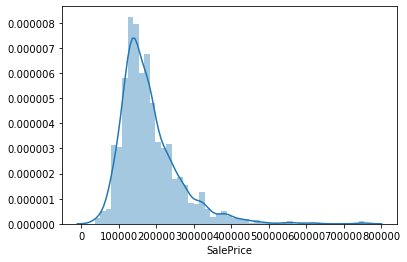

In [7]:
#Example of univariate exploration of the distribution of a variable, in this case - the target
sns.distplot(df['SalePrice']);

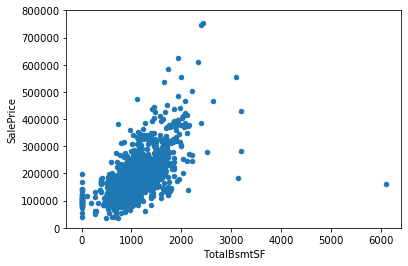

In [8]:
#Scatterint a feature in relation to the target
var = 'TotalBsmtSF'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

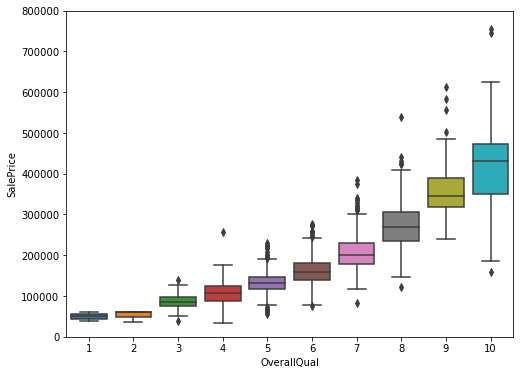

In [9]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

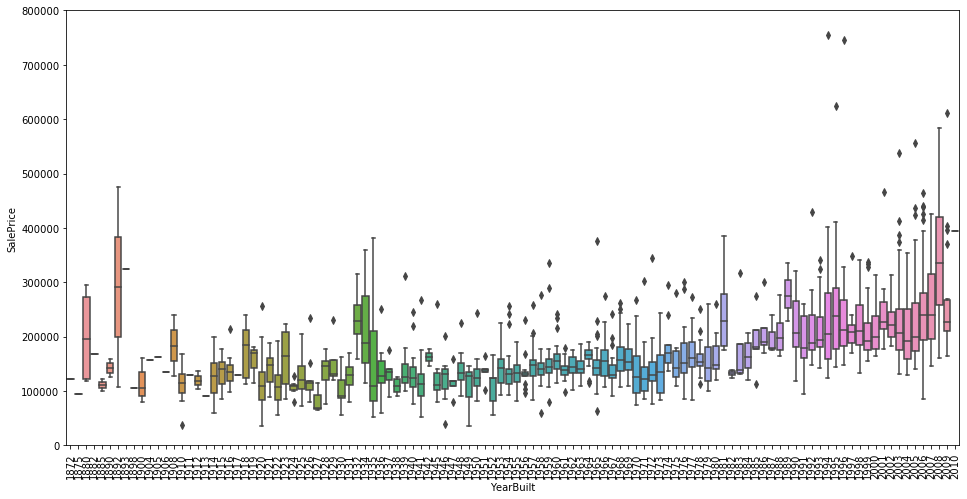

In [10]:
#These boxplot would be way better with bins - TODO
var = 'YearBuilt'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

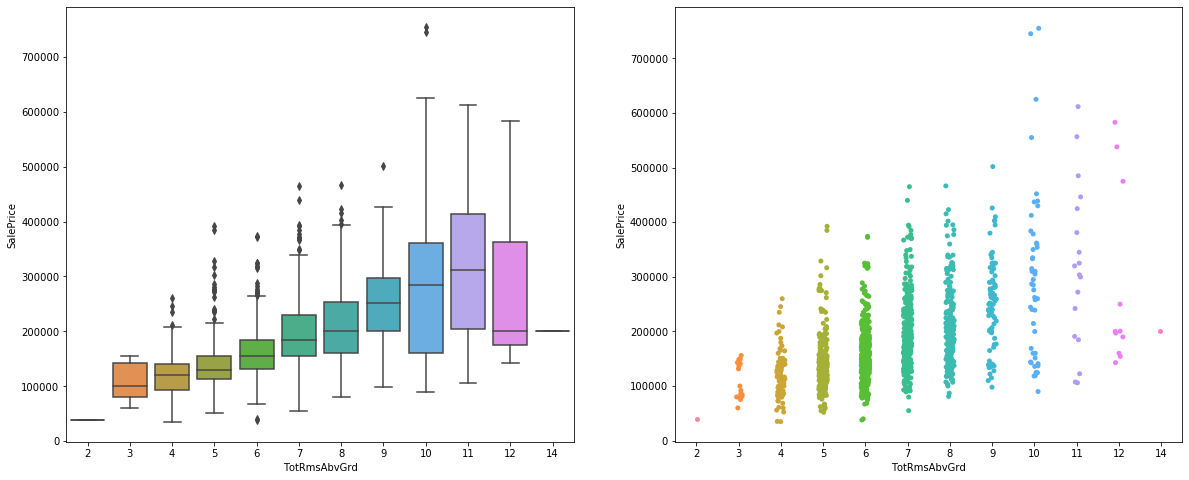

In [11]:
feature = "TotRmsAbvGrd"
rotation1 = 0
rotation2 = 0

fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,0]))
plt.xticks(rotation = rotation1)
sns.stripplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,1]))
plt.xticks(rotation = rotation2)
fig.show()

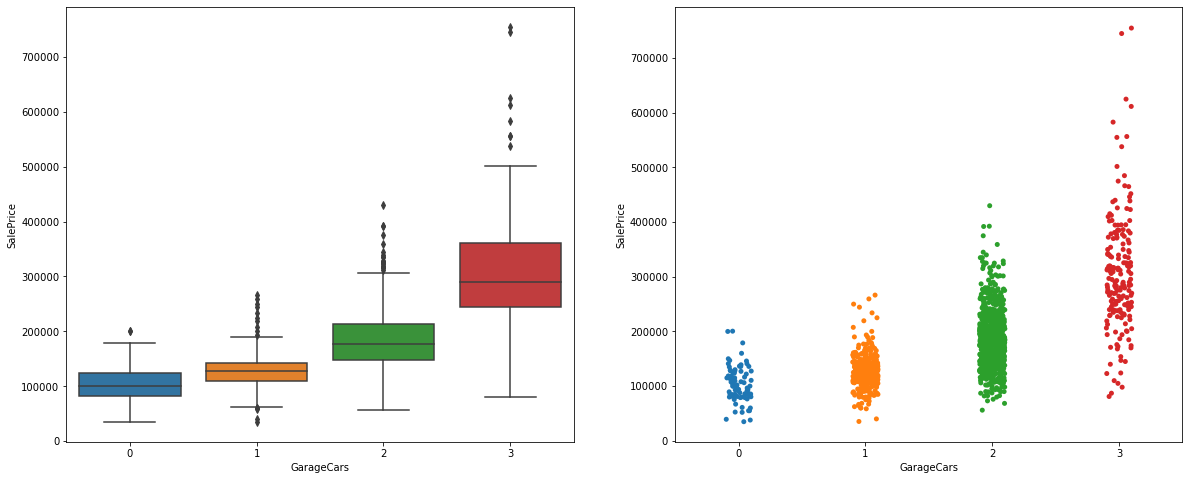

In [12]:
feature = "GarageCars"
rotation1 = 0
rotation2 = 0


df.GarageCars = df.GarageCars.apply(lambda x: 3 if x>3 else x)

fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,0]))
plt.xticks(rotation = rotation1)
sns.stripplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,1]))
plt.xticks(rotation = rotation2)
fig.show()

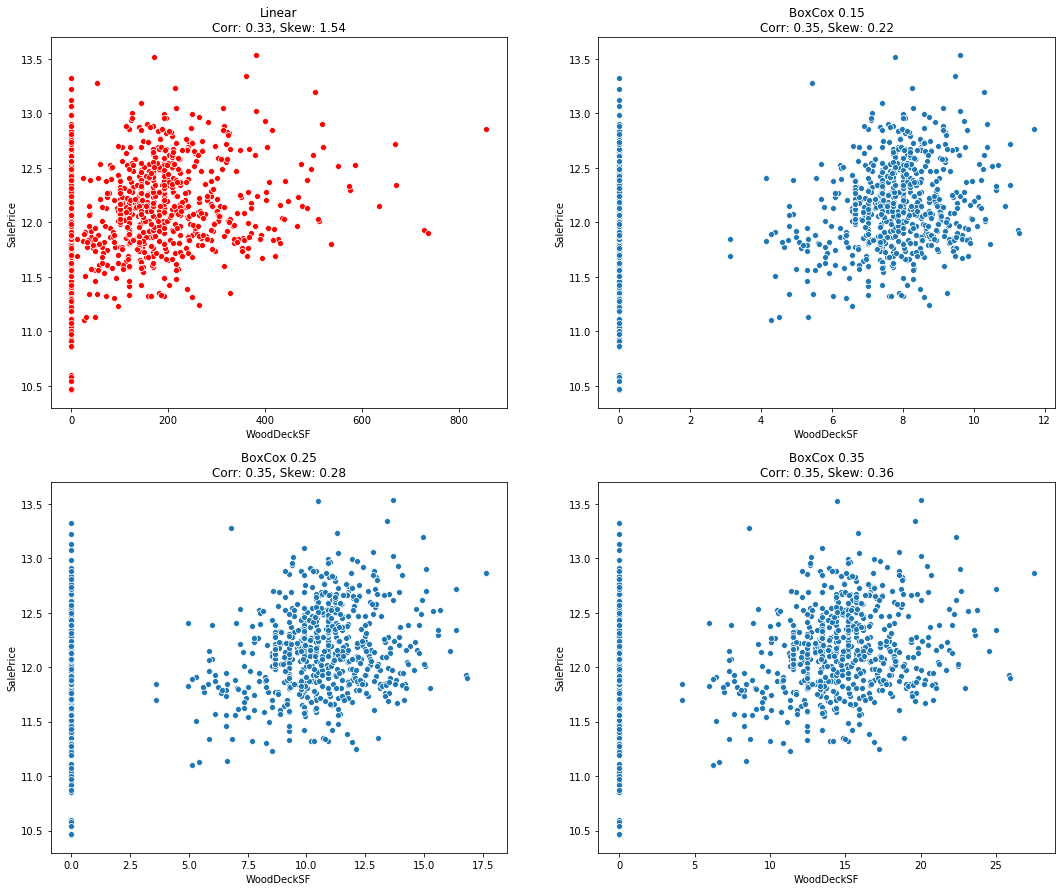

In [13]:
feature = 'WoodDeckSF'

    
fig = plt.figure(figsize=(18,15))
gs = GridSpec(2,2)
    
j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                    x=boxcox1p(df[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(boxcox1p(df[feature], 0.15)),2)) + ', Skew: ' +
           str(np.round(st.skew(boxcox1p(df[feature], 0.15)),2)))

j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                    x=boxcox1p(df[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(boxcox1p(df[feature], 0.25)),2)) + ', Skew: ' +
           str(np.round(st.skew(boxcox1p(df[feature], 0.25)),2)))

j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                    x=boxcox1p(df[feature], 0.35), ax=fig.add_subplot(gs[1,1]), palette = 'blue')

plt.title('BoxCox 0.35\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(boxcox1p(df[feature], 0.35)),2)) + ', Skew: ' +
           str(np.round(st.skew(boxcox1p(df[feature], 0.35)),2)))

j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                    x=df[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

plt.title('Linear\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(df[feature]),2)) + ', Skew: ' + 
           str(np.round(st.skew(df[feature]),2)))

fig.show()

# Data Pre-Processing


## Nonsense values
Negative Values, etc

In [14]:
pd.set_option('display.max_columns', 100)
for col in df:
    print(col)
    print (df[col].unique())
    print('\n')


MSSubClass
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]


LotFrontage
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]


LotArea
[ 8450  9600 11250 ... 17217 13175  9717]


OverallQual
[ 7  6  8  5  9  4 10  3  1  2]


OverallCond
[5 8 6 7 4 2 3 9 1]


YearBuilt
[2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 19

In [15]:
display(df.describe(include = 'all')) #it helps to understand non-sense values

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count   1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
unique          NaN          NaN            NaN          NaN          NaN   
top             NaN          NaN            NaN          NaN          NaN   
freq            NaN          NaN            NaN          NaN          NaN   
mean      56.897260    70.049958   10516.828082     6.099315     5.575342   
std       42.300571    24.284752    9981.264932     1.382997     1.112799   
min       20.000000    21.000000    1300.000000     1.000000     1.000000   
25%       20.000000    59.000000    7553.500000     5.000000     5.000000   
50%       50.000000    69.000000    9478.500000     6.000000     5.000000   
75%       70.000000    80.000000   11601.500000     7.000000     6.000000   
max      190.000000   313.000000  215245.000000    10.000000     9.000000   

          YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count   1460.000000   1460.000000  1452.000000  1460.000000  1460.000000   
unique          NaN           NaN          NaN          NaN          NaN   
top             NaN           NaN          NaN          NaN          NaN   
freq            NaN           NaN          NaN          NaN          NaN   
mean    1971.267808   1984.865753   103.685262   443.639726    46.549315   
std       30.202904     20.645407   181.066207   456.098091   161.319273   
min     1872.000000   1950.000000     0.000000     0.000000     0.000000   
25%     1954.000000   1967.000000     0.000000     0.000000     0.000000   
50%     1973.000000   1994.000000     0.000000   383.500000     0.000000   
75%     2000.000000   2004.000000   166.000000   712.250000     0.000000   
max     2010.000000   2010.000000  1600.000000  5644.000000  1474.000000   

          BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count   1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean     567.240411  1057.429452  1162.626712   346.992466      5.844521   
std      441.866955   438.705324   386.587738   436.528436     48.623081   
min        0.000000     0.000000   334.000000     0.000000      0.000000   
25%      223.000000   795.750000   882.000000     0.000000      0.000000   
50%      477.500000   991.500000  1087.000000     0.000000      0.000000   
75%      808.000000  1298.250000  1391.250000   728.000000      0.000000   
max     2336.000000  6110.000000  4692.000000  2065.000000    572.000000   

          GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count   1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
unique          NaN           NaN           NaN          NaN          NaN   
top             NaN           NaN           NaN          NaN          NaN   
freq            NaN           NaN           NaN          NaN          NaN   
mean    1515.463699      0.425342      0.057534     1.565068     0.382877   
std      525.480383      0.518911      0.238753     0.550916     0.502885   
min      334.000000      0.000000      0.000000     0.000000     0.000000   
25%     1129.500000      0.000000      0.000000     1.000000     0.000000   
50%     1464.000000      0.000000      0.000000     2.000000     0.000000   
75%     1776.750000      1.000000      0.000000     2.000000     1.000000   
max     5642.000000      3.000000      2.000000     3.000000     2.000000   

        BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt  \
count    1460.000000   1460.000000   1460.000000  1460.000000  1379.000000   
unique           NaN           NaN           NaN          NaN          NaN   
top              NaN           NaN           NaN          NaN          NaN   
freq             NaN 

## Missing Values


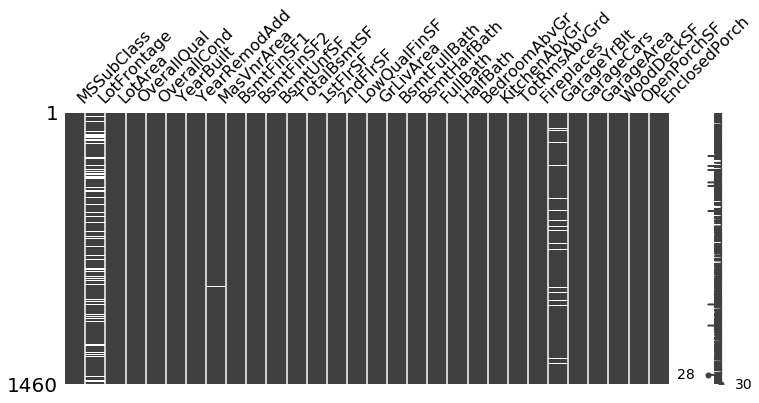

In [16]:
missingno.matrix(df.iloc[:,0:30], figsize=(12, 5))

In [17]:
df.isnull().sum()

MSSubClass       0
LotFrontage    259
LotArea          0
OverallQual      0
OverallCond      0
              ... 
Condition1       0
GarageCond      81
Heating          0
Utilities        0
SalePrice        0
Length: 80, dtype: int64

In [18]:
columns = df.columns

imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=False)
df = pd.DataFrame(imputer.fit_transform(df))

df.columns = columns 

#droping features with more than 85% missing features
#df = df.dropna(thresh=len(df)*0.85, axis=1)

#total = df.isnull().sum().sort_values(ascending=False)
#percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
#missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#df = df.drop((missing_data[missing_data['Total'] > 1]).index,1)
#df = df.drop(df.loc[df['Electrical'].isnull()].index)


"""  

for col in df.columns:
    df[col].fillna(df[col].mode(), inplace=True)


#fill the NaN values with the mode. It could be filled with median, mean, etc
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

#we could fill every missing values with medians of the columns
#df = data.fillna(df.median())

#also, instead of fill, we can remove every row in which 10% of the values are missing
# df = df.loc[df.isnull().mean(axis=1) < 0.1]    
"""
"""
#It is possible to use an imputer. and fill with the values of median, mean, etc
#If imputation technique is used, it is a good practice to add an additional binary feature as a missing indicator.
imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=True)
imputer = SimpleImputer(strategy='mean')
imputer = SimpleImputer(strategy='median')
imputer = SimpleImputer(strategy='constant')
df = pd.DataFrame(imputer.fit_transform(df))
"""

"""
# It is also possible to run a bivariate imputer (iterative imputer). However, it is needed to do labelencoding first. The code below enables us to run the imputer with a Random Forest estimator
# The Iterative Imputer is developed by Scikit-Learn and models each feature with missing values as a function of other features. It uses that as an estimate for imputation. At each step, a feature is selected as output y and all other features are treated as inputs X. A regressor is then fitted on X and y and used to predict the missing values of y. This is done for each feature and repeated for several imputation rounds.
# The great thing about this method is that it allows you to use an estimator of your choosing. I used a RandomForestRegressor to mimic the behavior of the frequently used missForest in R.
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)
df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

#If you have sufficient data, then it might be an attractive option to simply delete samples with missing data. However, keep in mind that it could create bias in your data. Perhaps the missing data follows a pattern that you miss out on.

#The Iterative Imputer allows for different estimators to be used. After some testing, I found out that you can even use Catboost as an estimator! Unfortunately, LightGBM and XGBoost do not work since their random state names differ.
"""

'\n# It is also possible to run a bivariate imputer (iterative imputer). However, it is needed to do labelencoding first. The code below enables us to run the imputer with a Random Forest estimator\n# The Iterative Imputer is developed by Scikit-Learn and models each feature with missing values as a function of other features. It uses that as an estimate for imputation. At each step, a feature is selected as output y and all other features are treated as inputs X. A regressor is then fitted on X and y and used to predict the missing values of y. This is done for each feature and repeated for several imputation rounds.\n# The great thing about this method is that it allows you to use an estimator of your choosing. I used a RandomForestRegressor to mimic the behavior of the frequently used missForest in R.\nimp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)\ndf = pd.DataFrame(imp.fit_transform(df), columns=df.columns)\n\n#If you have sufficient data, then it mig

In [19]:
display(df.isnull().sum())

MSSubClass     0
LotFrontage    0
LotArea        0
OverallQual    0
OverallCond    0
              ..
Condition1     0
GarageCond     0
Heating        0
Utilities      0
SalePrice      0
Length: 80, dtype: int64

(more examples of operations for replacing values if needed in the future)

In [20]:
"""
#Replace specific values if needed
Replace symbol in whole column
df['age'] = df['age'].str.replace('–', '**', regex = True)


#DROP multiple columns
df.drop(['age' , 'fnlwgt'], axis = 1, inplace = True)


#Find text with regex and replace with nothing
 df = df.replace({
     'age':'[A-Za-z]', 
     'fnlwgt': '[A-Za-z]',
 },'',regex = True)


#Example of applying a formula to entire column

 def euro(cell):
     cell = cell.strip('€')
     return cell
 df.Wage = df.Wage.apply(euro)

#Insert value in cell depending on values from other cells
 def impute_age(cols):
     age = cols[0]
     Pclass = cols[1]
     if pd.isnull(Age):
         if Pclass == 1:
             return 37
         else:
             return 24
     else:
         return Age
         
#CHANGING DATA TYPES
#changing values to float
df[['Value','Wage','Age']].apply(pd.to_numeric, errors = 'coerce')
df.column.astype(float)
df.dtypes
"""

"\n#Replace specific values if needed\nReplace symbol in whole column\ndf['age'] = df['age'].str.replace('–', '**', regex = True)\n\n\n#DROP multiple columns\ndf.drop(['age' , 'fnlwgt'], axis = 1, inplace = True)\n\n\n#Find text with regex and replace with nothing\n df = df.replace({\n     'age':'[A-Za-z]', \n     'fnlwgt': '[A-Za-z]',\n },'',regex = True)\n\n\n#Example of applying a formula to entire column\n\n def euro(cell):\n     cell = cell.strip('€')\n     return cell\n df.Wage = df.Wage.apply(euro)\n\n#Insert value in cell depending on values from other cells\n def impute_age(cols):\n     age = cols[0]\n     Pclass = cols[1]\n     if pd.isnull(Age):\n         if Pclass == 1:\n             return 37\n         else:\n             return 24\n     else:\n         return Age\n         \n#CHANGING DATA TYPES\n#changing values to float\ndf[['Value','Wage','Age']].apply(pd.to_numeric, errors = 'coerce')\ndf.column.astype(float)\ndf.dtypes\n"

## Duplicates

In [21]:
print(df.duplicated().sum()) #check if there are duplicates
df.drop_duplicates(keep = 'first', inplace = True) #get rid of them

0


## Feature Transformation/Creation
- Feature Transformation (Modidy existing features) -> Scaling, normalize, standarize, logarithim, ...
- Feature Creation (Add useful features) -> Modify to new, Combine features, Cluster some feature, ...

### Label Encoding

In [22]:
#using labelencoder
label_encoders = [] #this was needed to reverse label encoding later
le = LabelEncoder()
for feature in categorical:
    new_le = copy.deepcopy(le)
    df[feature] = new_le.fit_transform(df[feature])
    label_encoders.append(new_le)
        
        

## Finding Outliers

We can detect outliers in 3 ways:

- Standard Deviation
- Percentiles (Tukey method)
- Isolation Forest or LocalOutlierFactor (more appropriate for Anomaly/Fraud Detection Problems)

Then, we can handle them by:
 - Remove them
 - Change them to max/min limit
 
The definition of outlier is quite dubious, but we can defined them as those values that surpasse the limit of 1.5 * IQR.
In this case, either the standard deviation method or Tukey method are valid options. We just need to try and see which gives better results (if it produces better results at all).

Text(0.5, 0.98, 'Plots showing Outliers')

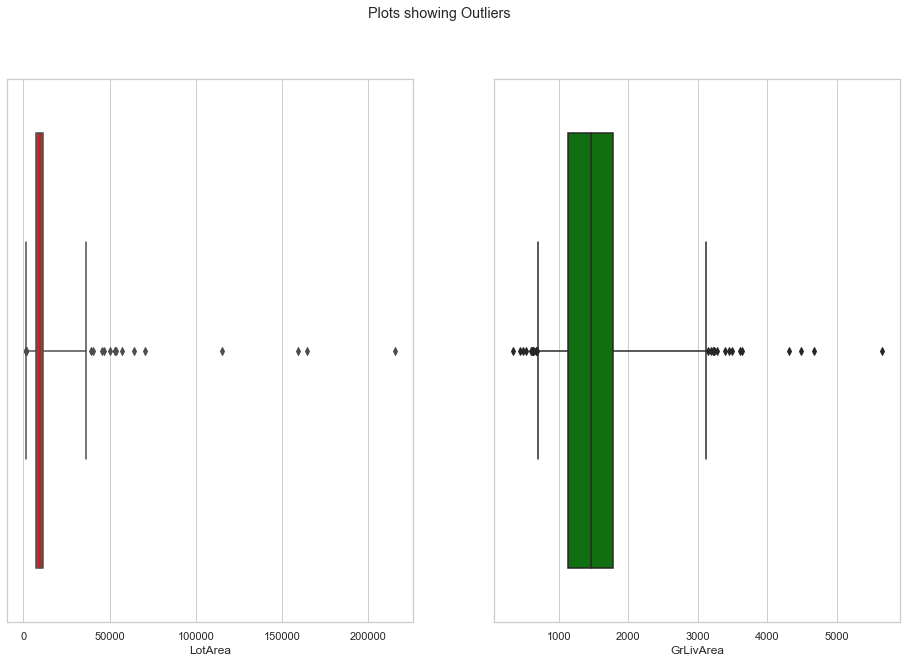

In [23]:
# Example of Outlier Visualization of two features
sns.set(style='whitegrid')
f,ax=plt.subplots(1,2,figsize=(16,10))
sns.boxplot(df.LotArea,ax=ax[0],color='red', whis=[1,99])
sns.boxplot(df.GrLivArea,ax=ax[1],color='green', whis=[1,99])
plt.suptitle('Plots showing Outliers')

In [24]:
# Tukey Method

n = 2 #In this case, we considered outliers as rows that have at least two outlied numerical values. The optimal value for this parameter can be later determined though the cross-validation
indexes = []

for col in df.columns[0:14]:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col],75)
    IQR = Q3 - Q1

    limit = 1.5 * IQR

    list_outliers = df[(df[col] < Q1 - limit) | (df[col] > Q3 + limit )].index # Determine a list of indices of outliers for feature col

    indexes.extend(list_outliers) # append the found outlier indices for col to the list of outlier indices 

indexes = Counter(indexes)        
multiple_outliers = list( k for k, v in indexes.items() if v > n )

df.drop(multiple_outliers, axis = 0)

df = df.drop(multiple_outliers, axis = 0).reset_index(drop=True)
print(str(len(multiple_outliers)) + " outliers were eliminated")

42 outliers were eliminated


In [25]:
#You can try with this method to see if it provides better results
"""
#Setting the min/max to outliers using standard deviation
for col in df.columns[0:14]:
    factor = 3 #The optimal value for this parameter can be later determined though the cross-validation
    upper_lim = df[col].mean () + df[col].std () * factor
    lower_lim = df[col].mean () - df[col].std () * factor

    df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]
"""

'\n#Setting the min/max to outliers using standard deviation\nfor col in df.columns[0:14]:\n    factor = 3 #The optimal value for this parameter can be later determined though the cross-validation\n    upper_lim = df[col].mean () + df[col].std () * factor\n    lower_lim = df[col].mean () - df[col].std () * factor\n\n    df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]\n'

## Transforming Skewed Continuous Features

In [26]:
def analyze_skew():
    #analyze which features are skewed
    fig = plt.figure(figsize = (35,20))
    cols = 3
    rows = math.ceil(float(df[numerical].shape[1] / cols))
    for i, column in enumerate(numerical):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if df.dtypes[column] == np.object:
            df[column].value_counts().plot(kind = 'bar', axes = ax)
        else:
            df[column].hist(axes = ax)
            plt.xticks(rotation = 'vertical')
    plt.subplots_adjust(hspace = 0.7, wspace = 0.2)
    plt.show()
    
    
    skew_feats = df[numerical].skew().sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew': skew_feats})
    
    display(skewness)
    return skewness

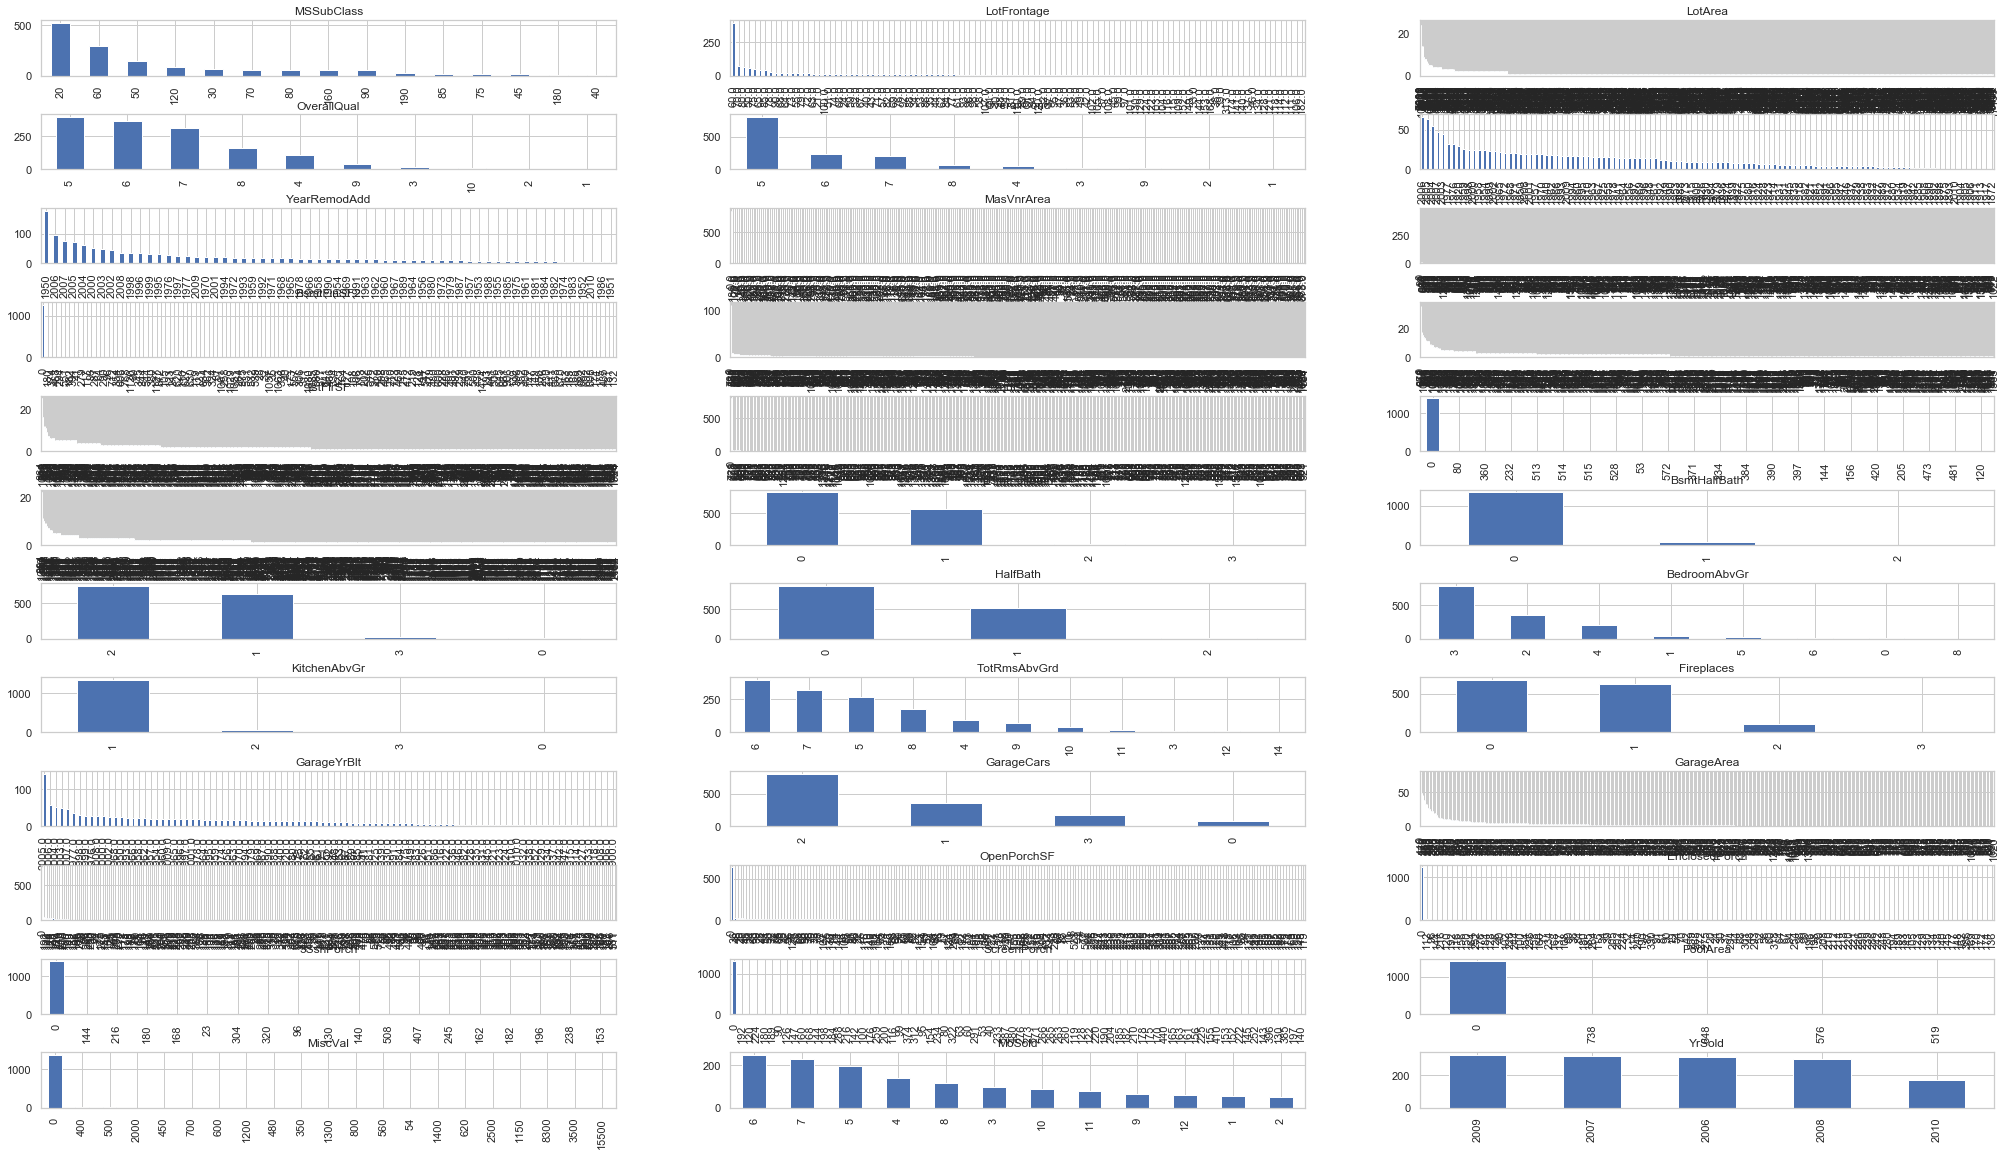

Skew
MiscVal        24.168023
PoolArea       19.258982
3SsnPorch      10.812301
LotArea        10.447853
LowQualFinSF    9.437954
BsmtFinSF2      4.542985
KitchenAbvGr    4.453881
BsmtHalfBath    4.130970
ScreenPorch     4.108116
EnclosedPorch   2.872395
MasVnrArea      2.578330
OpenPorchSF     2.355887
LotFrontage     2.013600
WoodDeckSF      1.557889
MSSubClass      1.425759
BsmtUnfSF       0.885788
GrLivArea       0.793859
2ndFlrSF        0.752557
TotRmsAbvGrd    0.705505
OverallCond     0.703074
HalfBath        0.693873
1stFlrSF        0.687285
BsmtFinSF1      0.674946
Fireplaces      0.645717
BsmtFullBath    0.599061
BedroomAbvGr    0.250177
TotalBsmtSF     0.230618
MoSold          0.209654
OverallQual     0.173152
GarageArea      0.108578
YrSold          0.101526
FullBath       -0.007711
GarageCars     -0.419157
YearRemodAdd   -0.500479
YearBuilt      -0.587506
GarageYrBlt    -0.706330

In [27]:
skewness = analyze_skew()

In [28]:
#Let's reduce the skew of the features that have a skewness greater than 0.85
skew_feats = df[numerical].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewed = skewness.index[abs(skewness.iloc[:, 0]) > 0.85].tolist()
df[skewed] = df[skewed].astype(float)

In [29]:
features_log_transformed = pd.DataFrame(data=df)
features_log_transformed[skewed] = df[skewed].apply(lambda x: np.log(x + 1)) #it can be other function like polynomial, but generally the log funtion is suitable

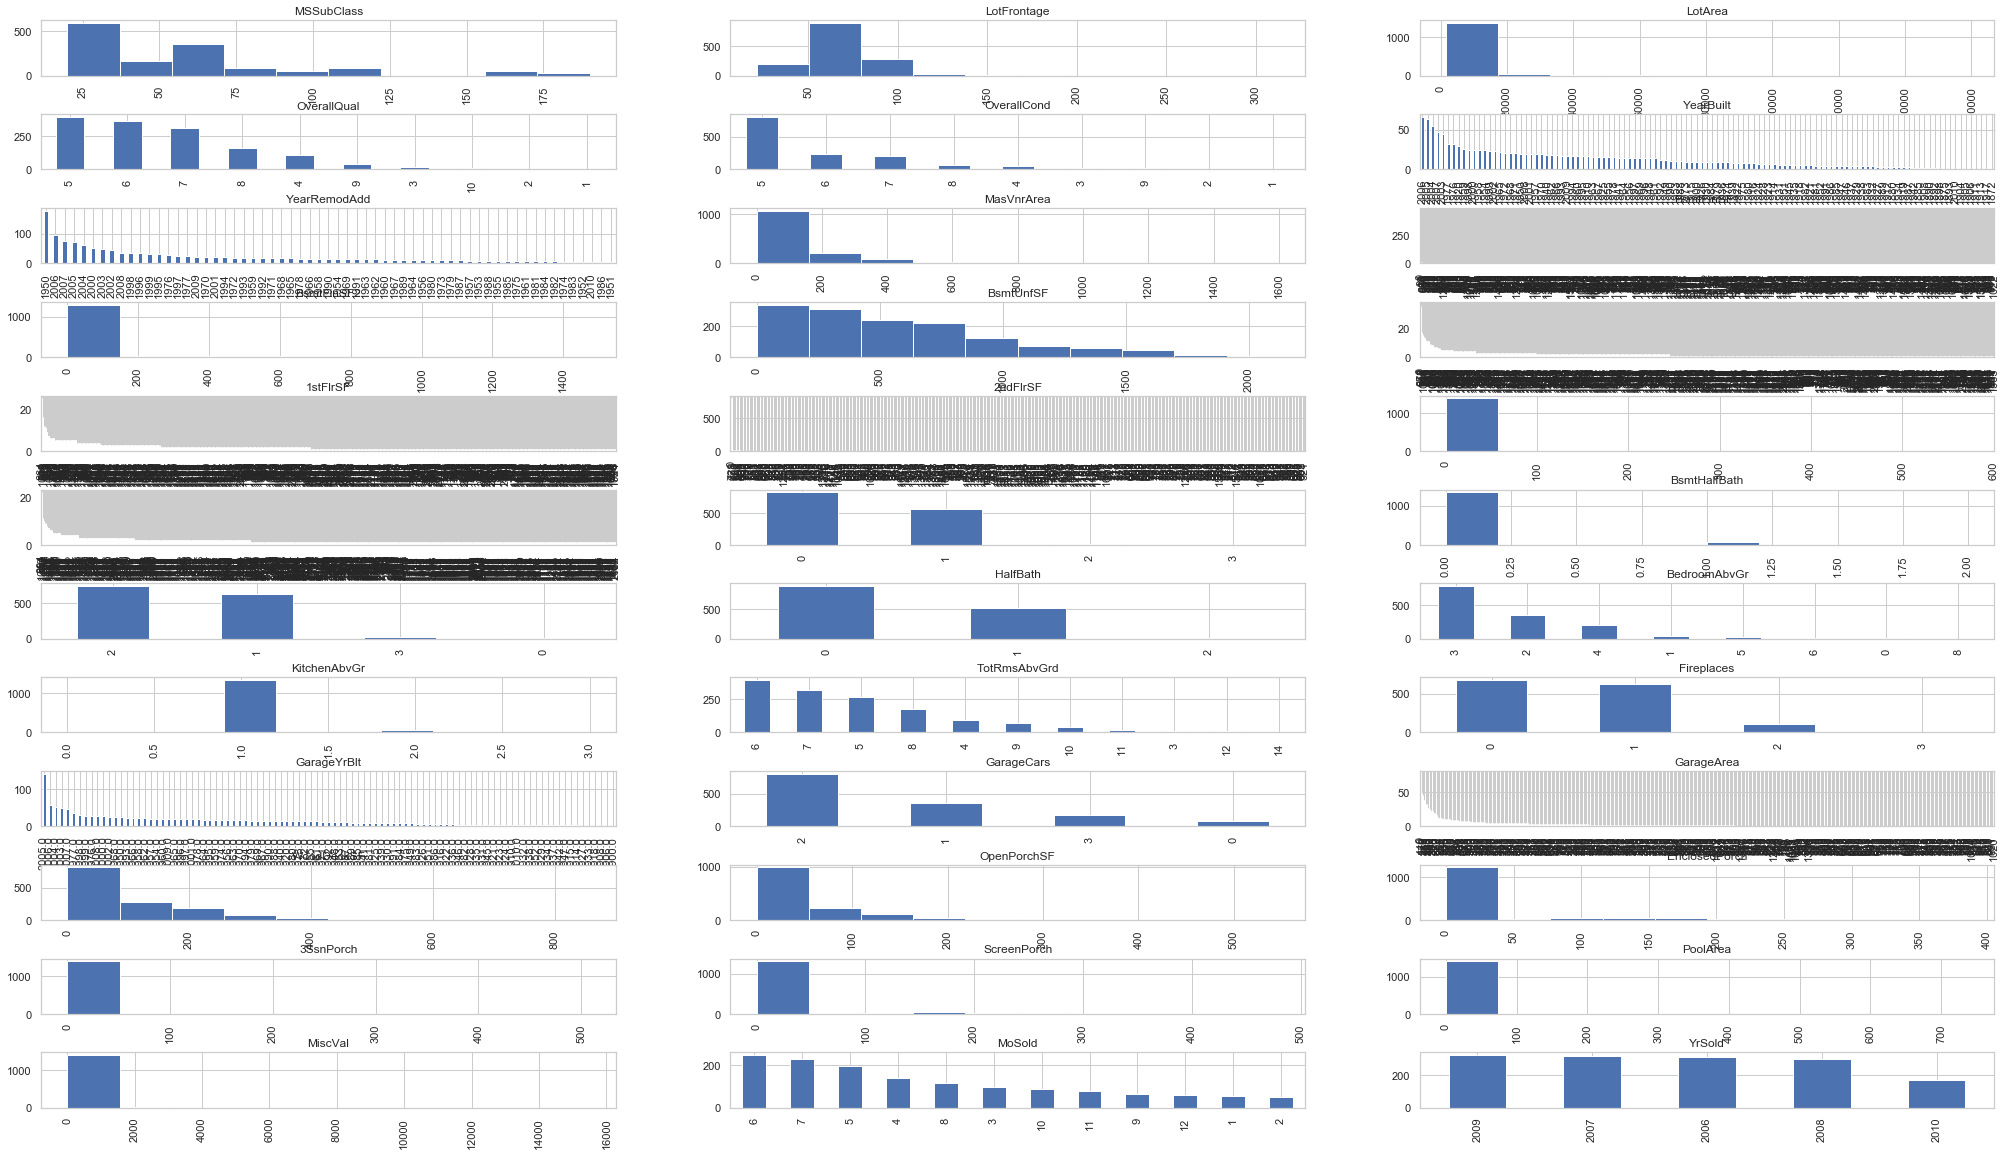

Skew
MiscVal        24.168023
PoolArea       19.258982
3SsnPorch      10.812301
LotArea        10.447853
LowQualFinSF    9.437954
BsmtFinSF2      4.542985
KitchenAbvGr    4.453881
BsmtHalfBath    4.130970
ScreenPorch     4.108116
EnclosedPorch   2.872395
MasVnrArea      2.578330
OpenPorchSF     2.355887
LotFrontage     2.013600
WoodDeckSF      1.557889
MSSubClass      1.425759
BsmtUnfSF       0.885788
GrLivArea       0.793859
2ndFlrSF        0.752557
TotRmsAbvGrd    0.705505
OverallCond     0.703074
HalfBath        0.693873
1stFlrSF        0.687285
BsmtFinSF1      0.674946
Fireplaces      0.645717
BsmtFullBath    0.599061
BedroomAbvGr    0.250177
TotalBsmtSF     0.230618
MoSold          0.209654
OverallQual     0.173152
GarageArea      0.108578
YrSold          0.101526
FullBath       -0.007711
GarageCars     -0.419157
YearRemodAdd   -0.500479
YearBuilt      -0.587506
GarageYrBlt    -0.706330

Skew
MiscVal        24.168023
PoolArea       19.258982
3SsnPorch      10.812301
LotArea        10.447853
LowQualFinSF    9.437954
BsmtFinSF2      4.542985
KitchenAbvGr    4.453881
BsmtHalfBath    4.130970
ScreenPorch     4.108116
EnclosedPorch   2.872395
MasVnrArea      2.578330
OpenPorchSF     2.355887
LotFrontage     2.013600
WoodDeckSF      1.557889
MSSubClass      1.425759
BsmtUnfSF       0.885788
GrLivArea       0.793859
2ndFlrSF        0.752557
TotRmsAbvGrd    0.705505
OverallCond     0.703074
HalfBath        0.693873
1stFlrSF        0.687285
BsmtFinSF1      0.674946
Fireplaces      0.645717
BsmtFullBath    0.599061
BedroomAbvGr    0.250177
TotalBsmtSF     0.230618
MoSold          0.209654
OverallQual     0.173152
GarageArea      0.108578
YrSold          0.101526
FullBath       -0.007711
GarageCars     -0.419157
YearRemodAdd   -0.500479
YearBuilt      -0.587506
GarageYrBlt    -0.706330

In [30]:
#check again if is everything ok
analyze_skew()

# Feature Selection
- Feature Selection/Reduction (Remove useless features) -> See feature importance, correlations, Dimensionality reduction,

As we only have 14 features, we are not pressured to make a feature selection/reduction in order to increase drastically the computing time of the algorithms. So, for now, we are going to investigate if there are features extremely correlated to each other. After tuning and choosing the best model, we are revisiting feature selection methods just in case we face overfitting or to see if we could achieve the same results with the chosen model but with fewer features.

## Correlation

Since we have a mix of numerical and categorical variables, we are going to analyze the correlation between them independently and then mixed. 

- Numerical & Numerical: Pearson correlation is a good one to use, although there are others.
- Categorical & Categorical: We will make use Chi-squared and uncertainty correlation methods through a library called dython. 
- Numerical & Categorical: We can use point biserial correlation (only if categorical variable is binary type), or ANOVA test.

In [31]:
Y = df['SalePrice']
X = df.drop('SalePrice',axis=1)

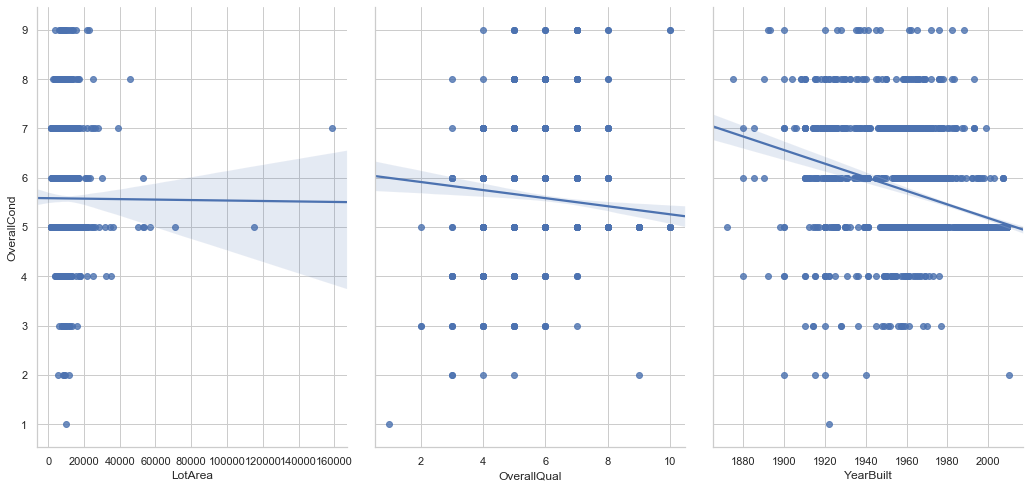

In [32]:
#Simple regression line of various variables in relation to  one other
sns.pairplot(X.astype(float), x_vars = ['LotArea', 'OverallQual', 'YearBuilt'], y_vars = 'OverallCond', size = 7, aspect = 0.7, kind = 'reg')

**Correlations between numerical features**

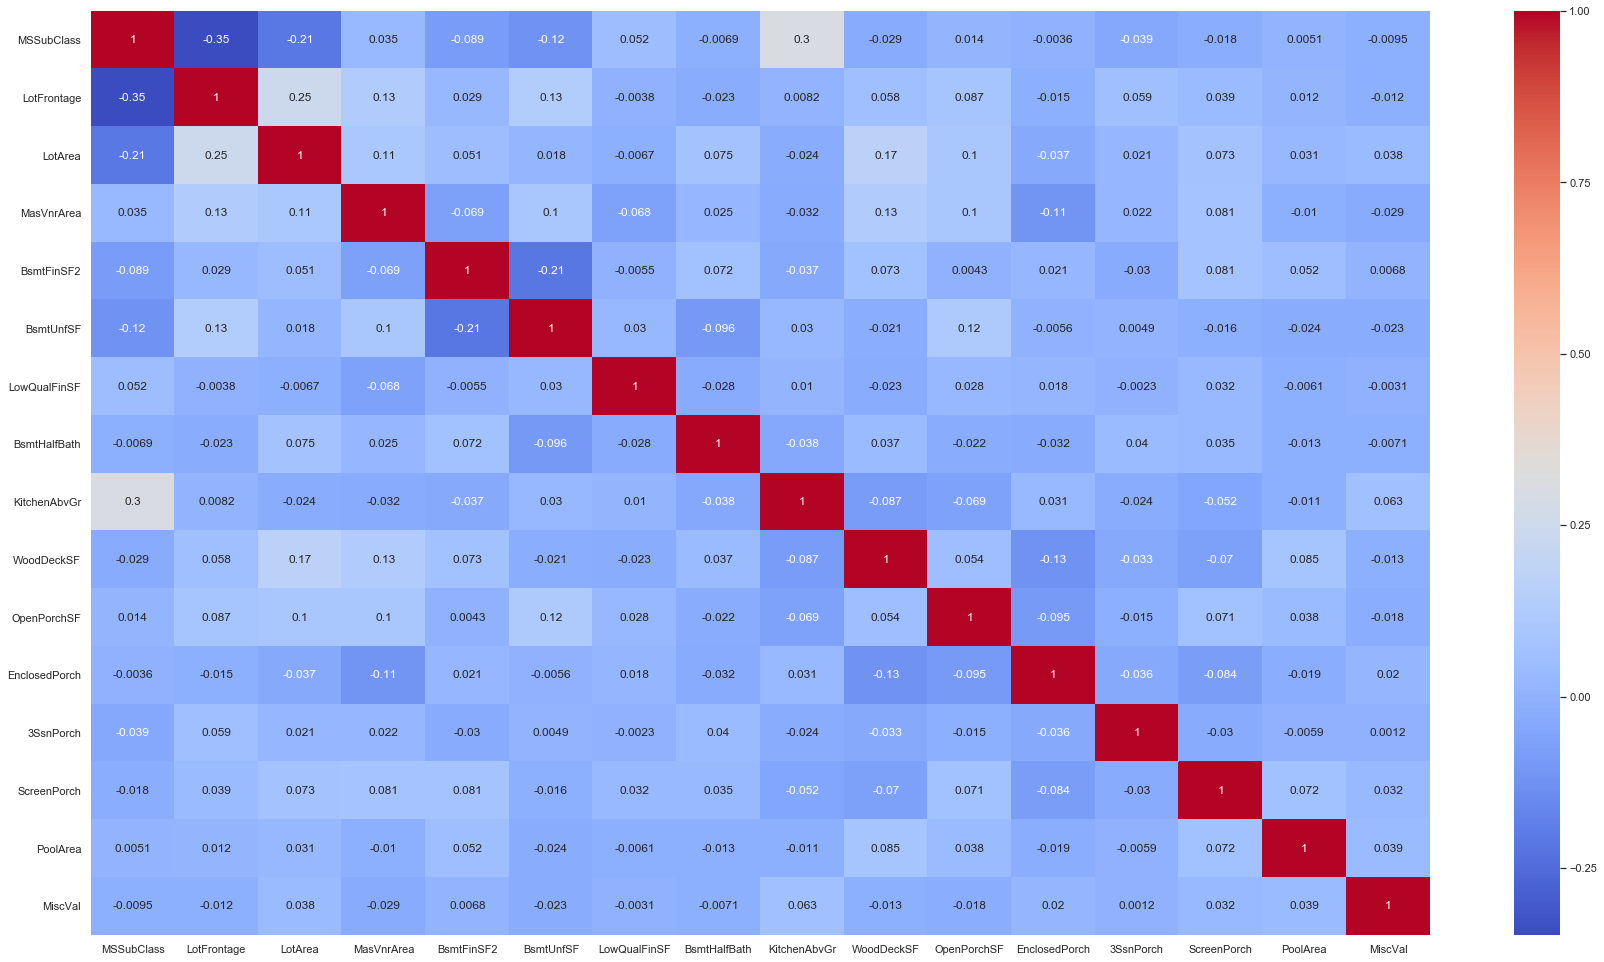

In [33]:
plt.subplots(figsize=(30,17))
sns.heatmap(X[numerical].corr(method = 'pearson'),annot=True,cmap='coolwarm') # the method can also be 'spearman' or kendall'

#to see the correlation between just two variables
#df['age'].corr(df['capital.gain']) 

**Correlations between categorical features**

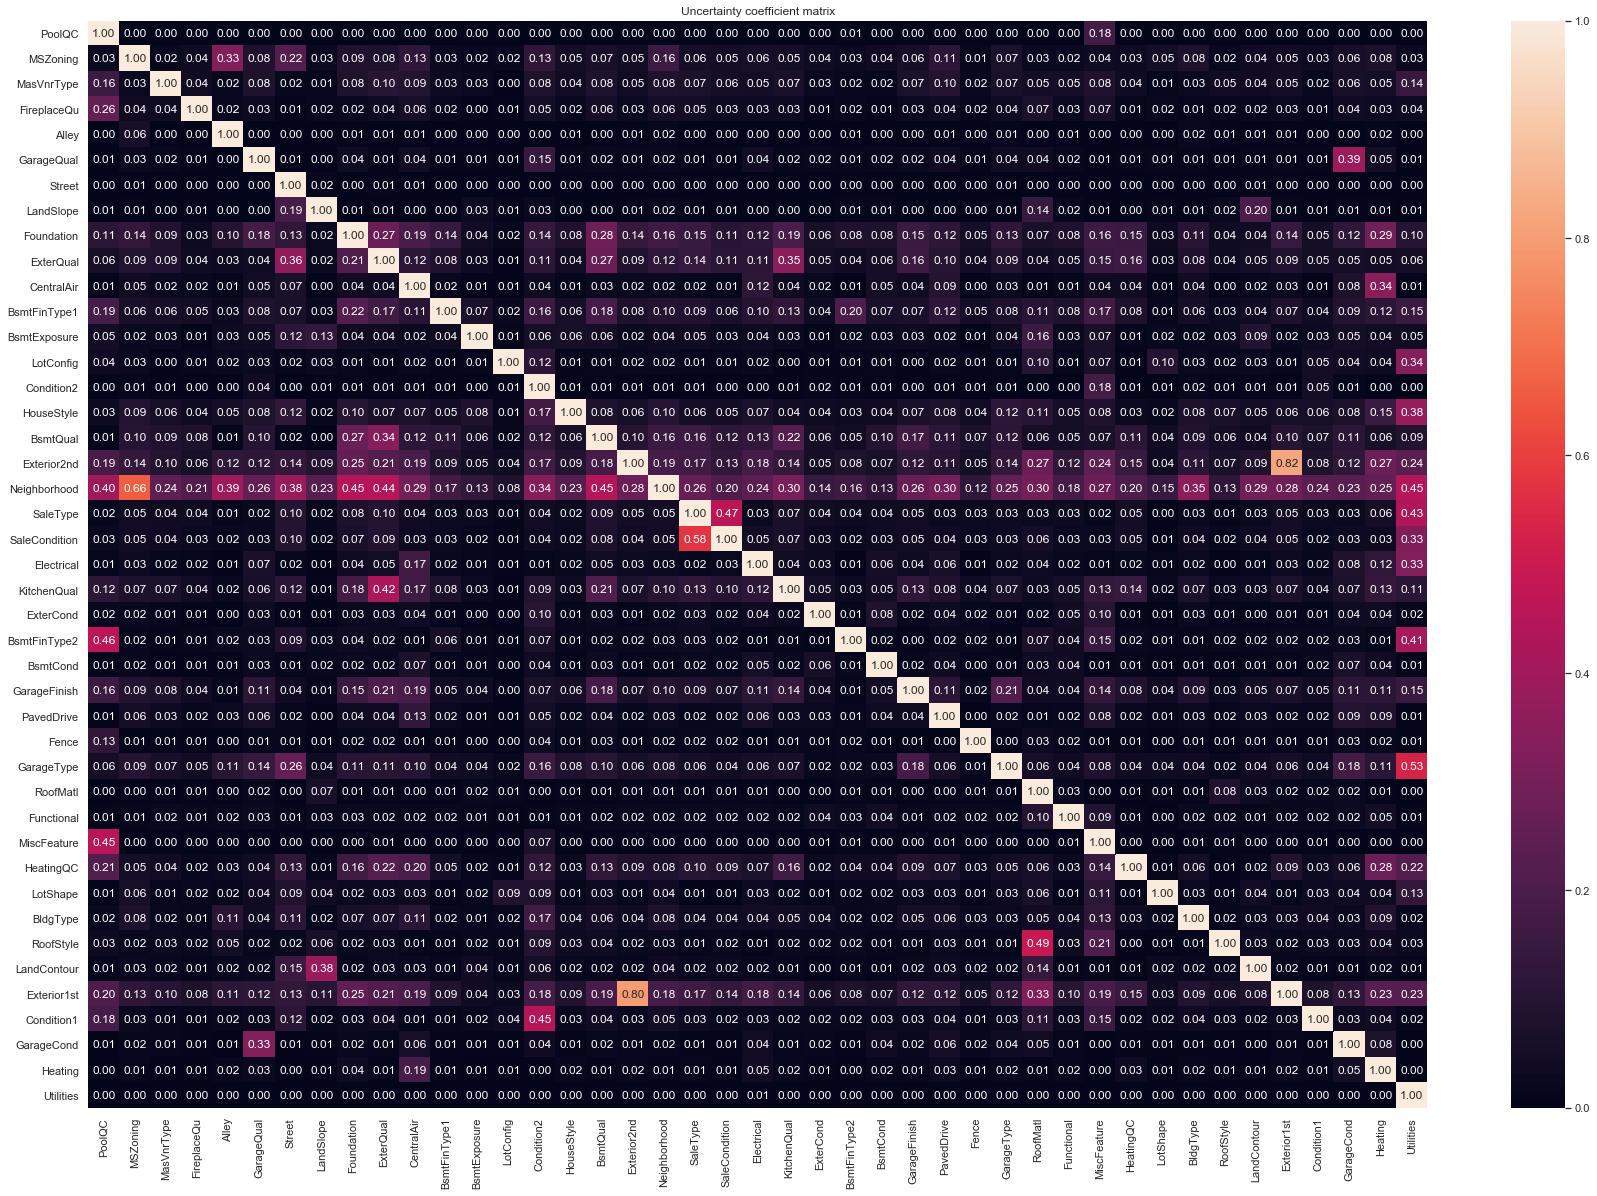

In [34]:
data = X[X.columns.intersection(categorical)]

cols = data.columns
clen = cols.size

pairings = list(itertools.product(data.columns, repeat=2))
theils_mat = np.reshape([nominal.theils_u(data[p[1]],data[p[0]]) for p in pairings],(clen,clen))
final = pd.DataFrame(theils_mat, index=cols, columns=cols)

fig, ax = plt.subplots(1,1, figsize=(30,20))
sns.heatmap(final,0,1,ax=ax,annot=True,fmt="0.2f").set_title("Uncertainty coefficient matrix")
plt.show()

**Correlations between categorical and numerical features**

In [35]:
for num_feature in numerical:
    for cat_feature in categorical:
        args_list = []
        for unique in X[cat_feature].unique():
            args_list.append(X[num_feature][X[cat_feature] == unique])
        
        f_val, p_val = st.f_oneway(*args_list) # Calculate f statistics and p value
        print("There are no statistical differences between the following pair of features:")
        
        if(p_val>0.05):
            print('Anova Result between ' + num_feature, ' & '+ cat_feature, ':' , f_val, p_val)  
        
        #TO-DO: reduce the features based on this

There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & PoolQC : 0.3056761296862853 0.5804329536402391
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & FireplaceQu : 0.9476471723884974 0.4354293042636793
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & Street : 0.1105528678915604 0.7395647939358603
There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & LandSlope : 1.020107272162186 0.36082126335208287
There are no statistical differences between the

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between LotFrontage  & Functional : 0.9743867162693991 0.441062245994709
There are no statistical differences between the following pair of features:
Anova Result between LotFrontage  & MiscFeature : 0.23273077066713913 0.873611554193902
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between LotFrontage  & LandContour : 2.5940093598672935 0.05116238345645636
There are no statistical differences between the following pair of features:
There are no statistical differences between

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between YearBuilt  & RoofMatl : 0.4138705048902016 0.870192185416246
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between YearBuilt  & MiscFeature : 0.7532335757899573 0.5204799751589693
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pai

There are no statistical differences between the following pair of features:
Anova Result between MasVnrArea  & MiscFeature : 0.5440893179790941 0.652177814677386
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between MasVnrArea  & Condition1 : 1.7023021277380088 0.09333696767062456
There are no statistical differences between the following pair of features:
Anova Result between MasVnrArea  & GarageCond : 2.2652121143740382 0.060149085054977985
There are no statistical differences between t

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between BsmtFinSF2  & BldgType : 1.3609826086900658 0.2452949158781257
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between BsmtFinSF2  & LandContour : 1.1526877335095265 0.3266373322567051
There are no statistical differences between the following pair of features:
There are no statistical differences between the following 

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between TotalBsmtSF  & Functional : 1.7175515176229963 0.11325241987994929
There are no statistical differences between the following pair of features:
Anova Result between TotalBsmtSF  & MiscFeature : 2.038765554006798 0.10659974937224129
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the follo

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between 2ndFlrSF  & RoofMatl : 0.7005276821133843 0.6492448691661015
There are no statistical differences between the following pair of features:
Anova Result between 2ndFlrSF  & Functional : 1.655451101125571 0.12841042536904704
There are no statistical differences between the following pair of features:
Anova Result between 2ndFlrSF  & MiscFeature : 2.303431702858505 0.07529084864142853
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the followi

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between GrLivArea  & ExterCond : 1.2397806378072658 0.29205609489677764
There are no statistical differences between the following pair of features:
Anova Result between GrLivArea  & BsmtFinType2 : 1.7998478740204826 0.10985638164043202
There are no statistical differences between the following pair of features:
Anova Result between GrLivArea  & BsmtCond : 2.138209575193778 0.09359275664214158
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the fo

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between BsmtHalfBath  & SaleType : 0.9742355811850097 0.4543542110348906
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between BsmtHalfBath  & Electrical : 0.199710917051906 0.9385575738144055
There are no statistical differences between the following pair of features:
Anova Result between BsmtHalfBath  & KitchenQual : 0.6984877558970416 0.5529954097352803
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between 

There are no statistical differences between the following pair of features:
Anova Result between HalfBath  & BsmtFinType1 : 1.8237482170337846 0.10517726209935578
There are no statistical differences between the following pair of features:
Anova Result between HalfBath  & BsmtExposure : 1.7569501993280856 0.15352727166835728
There are no statistical differences between the following pair of features:
Anova Result between HalfBath  & LotConfig : 1.2061759454316505 0.30628184286577087
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the 

There are no statistical differences between the following pair of features:
Anova Result between KitchenAbvGr  & LandSlope : 0.9253506817721875 0.3966321237380057
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between KitchenAbvGr  & LotConfig : 1.9206525164541377 0.10455776557683139
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the follow

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between Fireplaces  & Condition2 : 1.6071920543989915 0.1414075079095931
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between Fireplaces  & SaleType : 1.9345576247747862 0.05139303946400997
There are no statistical differences between the following pair of features:
There are no statistical differences between the following 

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between GarageCars  & BsmtFinType2 : 1.9292315229648995 0.08663181029818302
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair 

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between WoodDeckSF  & Functional : 1.4182273417936209 0.20398038854951442
There are no statistical differences between the following pair of features:
Anova Result between WoodDeckSF  & MiscFeature : 0.5658410088116055 0.6375777117490817
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the followi

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between EnclosedPorch  & RoofMatl : 0.44200998397497493 0.8509291009213662
There are no statistical differences between the following pair of features:
Anova Result between EnclosedPorch  & Functional : 1.4112588414730032 0.20667897614151653
There are no statistical differences between the following pair of features:
Anova Result between EnclosedPorch  & MiscFeature : 0.6259760096424425 0.5982500252047949
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences be

There are no statistical differences between the following pair of features:
Anova Result between ScreenPorch  & MasVnrType : 1.059272378909967 0.36536834489033987
There are no statistical differences between the following pair of features:
Anova Result between ScreenPorch  & FireplaceQu : 2.107086621491476 0.0776861873460304
There are no statistical differences between the following pair of features:
Anova Result between ScreenPorch  & Alley : 0.2592184566822978 0.6107369203282358
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between ScreenPorch  & Street : 2.2287870411944075 0.13568292156932282
There are no statistical differences between the following pair of features:
Anova Result between ScreenPorch  & LandSlope : 1.9478769403311014 0.14295856856139424
There are no statistical differences between the following pair of features:
Anova Result between ScreenPorch  

There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between PoolArea  & BsmtCond : 0.11022835204731468 0.954142610362674
There are no statistical differences between the following pair of features:
Anova Result between PoolArea  & GarageFinish : 0.3437440361329077 0.7091696092219592
There are no statistical differences between the following pair of features:
Anova Result between PoolArea  & PavedDrive : 0.17858845292437744 0.836468917619073
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between PoolArea  & GarageType : 0.4309370359149834 0.8272616409870301
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between PoolArea  & Functional : 0.

Anova Result between MiscVal  & Utilities : 0.007748869039342253 0.929867138524108
There are no statistical differences between the following pair of features:
Anova Result between MoSold  & PoolQC : 1.505612814254419 0.22001372396566457
There are no statistical differences between the following pair of features:
Anova Result between MoSold  & MSZoning : 1.598275883197812 0.1723004259378906
There are no statistical differences between the following pair of features:
Anova Result between MoSold  & MasVnrType : 0.44651179654366596 0.719805104600394
There are no statistical differences between the following pair of features:
Anova Result between MoSold  & FireplaceQu : 0.40031744128741786 0.8085233703170245
There are no statistical differences between the following pair of features:
Anova Result between MoSold  & Alley : 1.6358706514877979 0.20110253439616238
There are no statistical differences between the following pair of features:
Anova Result between MoSold  & GarageQual : 0.18081907

There are no statistical differences between the following pair of features:
Anova Result between YrSold  & LotConfig : 0.6360622590081382 0.6368175323257771
There are no statistical differences between the following pair of features:
Anova Result between YrSold  & Condition2 : 0.3762110824521785 0.8944397798838715
There are no statistical differences between the following pair of features:
Anova Result between YrSold  & HouseStyle : 0.358748653851718 0.9260806751022976
There are no statistical differences between the following pair of features:
Anova Result between YrSold  & BsmtQual : 1.061366308937125 0.364458267293294
There are no statistical differences between the following pair of features:
Anova Result between YrSold  & Exterior2nd : 1.0402499968509253 0.4098549265642515
There are no statistical differences between the following pair of features:
Anova Result between YrSold  & Neighborhood : 1.0551031114053027 0.390660853783442
There are no statistical differences between the f

# Dimensionality Reduction

## T-SNE

In [36]:
train,test = train_test_split(df,test_size=0.3)

y_train = train['SalePrice']
X_train = train.drop('SalePrice',axis=1)
y_test = test['SalePrice']
X_test = test.drop('SalePrice',axis=1)

In [37]:
tsne = TSNE(n_components=2, random_state=42, verbose = 2)
TSNE_X = tsne.fit_transform(X_train)
TSNE_X_test = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 992 samples in 0.072s...
[t-SNE] Computed neighbors for 992 samples in 0.232s...
[t-SNE] Computed conditional probabilities for sample 992 / 992
[t-SNE] Mean sigma: 306.397643
[t-SNE] Computed conditional probabilities in 0.422s
[t-SNE] Iteration 50: error = 62.6985474, gradient norm = 0.2476057 (50 iterations in 4.014s)
[t-SNE] Iteration 100: error = 61.2124176, gradient norm = 0.2135668 (50 iterations in 3.525s)
[t-SNE] Iteration 150: error = 60.6853333, gradient norm = 0.2230535 (50 iterations in 3.590s)
[t-SNE] Iteration 200: error = 60.3946381, gradient norm = 0.2289008 (50 iterations in 3.256s)
[t-SNE] Iteration 250: error = 60.3341370, gradient norm = 0.2226477 (50 iterations in 3.741s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.334137
[t-SNE] Iteration 300: error = 0.7242045, gradient norm = 0.0008751 (50 iterations in 3.510s)
[t-SNE] Iteration 350: error = 0.6460025, gradient norm = 0.0002917

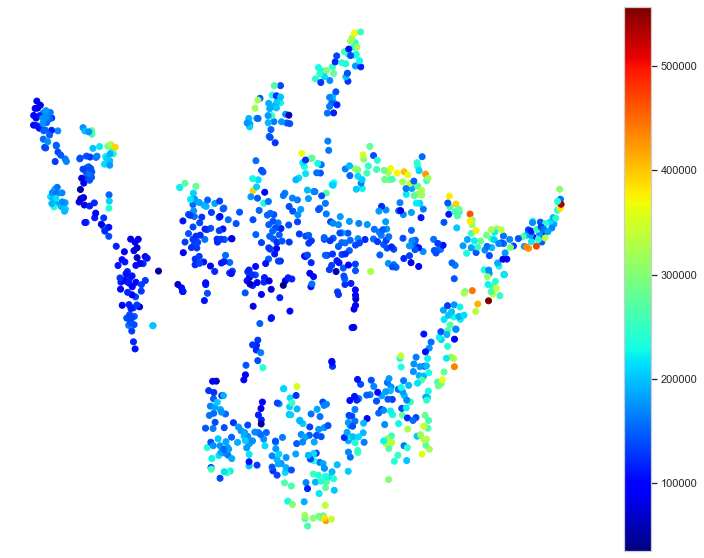

In [38]:
plt.figure(figsize=(13,10))
plt.scatter(TSNE_X[:, 0], TSNE_X[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

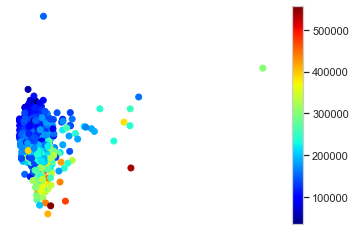

In [39]:
PCA_train_x = PCA(n_components=X_train.shape[1], random_state=42, svd_solver='full').fit_transform(X_train)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

## Kernel PCA

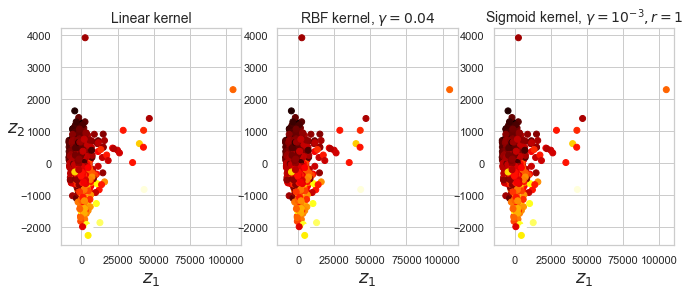

In [40]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Locally Linear Embedding

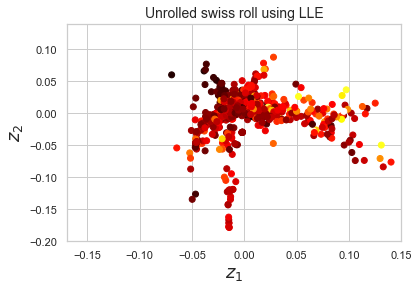

In [41]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
PCA_X = lle.fit_transform(X_train)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(PCA_X [:, 0], PCA_X [:, 1], c= y_train, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.170, 0.15, -0.200, 0.14])
plt.grid(True)
plt.show()

## PCA

In [42]:
#Scalling first a copy of the data
X_copy = X
col_names = X_copy.columns
features = X_copy[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X_copy[col_names] = features

n_comp = len(X_copy.columns)

pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X_copy)

print('Variance contributions of each feature:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])

Variance contributions of each feature:
0.12656282994340962
0.05310676560280521
0.045097567501365954
0.03838679409999979
0.029418060490109553
0.02691793186343873
0.02546092182433147
0.02337001685869521
0.022094231659405095
0.021094790139611224
0.02049417468797445
0.020191894604247446
0.01900492918884963
0.018225822355359498
0.017705171367265703
0.017110243980136337
0.016150883306699778
0.015396002894423477
0.015012097735486831
0.014577924980428498
0.014448563962210953
0.014002235396286183
0.013929615560892231
0.013798608611308927
0.013405510787998709
0.013054777984304464
0.012636094234299365
0.012291389476473416
0.012088587949140514
0.011651801725407822
0.011382688183029864
0.011130896208712002
0.010893152855149439
0.010652726860997042
0.010356584243811568
0.009954106675436515
0.009715838878034413
0.00963010016465691
0.009447645997323941
0.009228906369287799
0.009087324717417121
0.008688670553248271
0.008391409453572127
0.007991197656541967
0.007833884624484339
0.007720188968021385
0.0

To-Do: execute the PCA because there are features with meaningful variance

## PCA + T-SNE

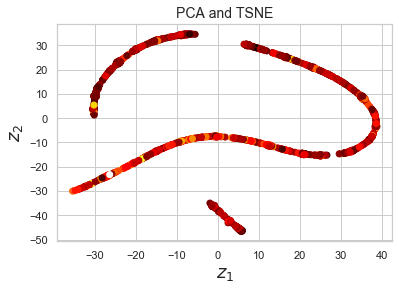

In [43]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42))
])
X_pca_tsne = pca_tsne.fit_transform(X_train)
plt.title("PCA and TSNE", fontsize=14)
plt.scatter(X_pca_tsne [:, 0], X_pca_tsne [:, 1], c= y_train, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.show()

It is difficult to separate the clusters.

In [44]:
#Saving data before OneHotEncoding to assess future importance later
X_not_encoded = copy.deepcopy(X)
X_not_encoded[X.columns] = StandardScaler().fit_transform(X) #not encoded yet, but scaled!

# Constructing the Pipeline | One Hot Encoding | Standardization

After analyzing the data and all the feature engineering possibilities, methods and what results from them, it is important to build an ML pipeline, i.e, a structure that encodes the sequence of all the transformations needed to each feature. 

This is particularly usefull for making predictions on new data. We want to transform new prediction data futurely to the standard with which our models were trained. 

We couldn't do at first because we had to know first if it would be needed to eliminate outliers or not, it would be needed to make reduce dimensionality, etc. Those operations can change the number of features left or created when we encode posteriorly.

So, our pipeline will only cover operations that can change the value and number of final features, and not other feature engineering aspects like class imbalance, skewness, outliers, etc.

- 1) We'll revert all the feature transformations absolutely needed to deal with class imbalance, skewness, outliers, pca, etc. For example: to check if a pca was needed, we had to standardize the values; to eliminate outliers, we had to encode the categorical variables before...So, in the end of this, we are able to fit the pipeline with all the data cleaned and with the original structure. 
      - Revert scaler -> binning -> label encoding
- 2) Construct and fit the pipeline with:
      - imputer (we want our model to be able to predict new data with missing fields) -> binning -> hot encoding -> scaler -> pca

We don't need to aggregate a preferred classifier right now to the pipeline because we will still assess and tune multiple models.

In [45]:
#inverse scaling X
X = pd.DataFrame(scaler.inverse_transform(X))
X.columns = df.columns[:-1]

#inverse label encoding X
for index, feature in enumerate(categorical):
    X[feature] = label_encoders[index].inverse_transform(X[feature].astype(int))


numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=False)),
    ('onehot', OneHotEncoder(categories="auto", handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers = [
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


temp = pipeline.fit_transform(X)
columns = numerical + pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical).tolist()

X = pd.DataFrame(temp.toarray(), columns=columns)


#Save the pipeline for later loading and make new predictions
joblib.dump(pipeline, './models/house_prices/preprocessing_pipeline.pkl')


['./models/house_prices/preprocessing_pipeline.pkl']

In [46]:
scaler_2 = StandardScaler().fit(Y.values.reshape(-1, 1))
Y = scaler_2.transform(Y.values.reshape(-1, 1))
Y = pd.DataFrame(Y, columns = ['SalePrice'])

In [47]:
# Here's code if we want to one hot encode just the categorical features without pipeline nd merge them with the numerical data for further standardization!
"""
encoder = OneHotEncoder(categories="auto")
encoded_feat = pd.DataFrame(encoder.fit_transform(df[categorical]).toarray(), columns=encoder.get_feature_names(categorical))

#concatenate without adding null values -.-''
l1=encoded_feat.values.tolist()
l2=df[numerical].values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])

X=pd.DataFrame(l1,columns=encoded_feat.columns.tolist()+df[numerical].columns.tolist())
"""

'\nencoder = OneHotEncoder(categories="auto")\nencoded_feat = pd.DataFrame(encoder.fit_transform(df[categorical]).toarray(), columns=encoder.get_feature_names(categorical))\n\n#concatenate without adding null values -.-\'\'\nl1=encoded_feat.values.tolist()\nl2=df[numerical].values.tolist()\nfor i in range(len(l1)):\n    l1[i].extend(l2[i])\n\nX=pd.DataFrame(l1,columns=encoded_feat.columns.tolist()+df[numerical].columns.tolist())\n'

In [48]:
# Here's code if we want to standardize without pipeline.
#Standard
"""
col_names = X.columns

features = X[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X[col_names] = features
"""

'\ncol_names = X.columns\n\nfeatures = X[col_names]\n\nscaler = StandardScaler().fit(features.values)\nfeatures = scaler.transform(features.values)\n\nX[col_names] = features\n'

In [49]:
#We can also try the minimax and see if it results in better performances
"""
#Minimax
col_names = X.columns

features = X[col_names]

scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

X[col_names] = features
"""

'\n#Minimax\ncol_names = X.columns\n\nfeatures = X[col_names]\n\nscaler = MinMaxScaler().fit(features.values)\nfeatures = scaler.transform(features.values)\n\nX[col_names] = features\n'

# Colinearity After Encoding

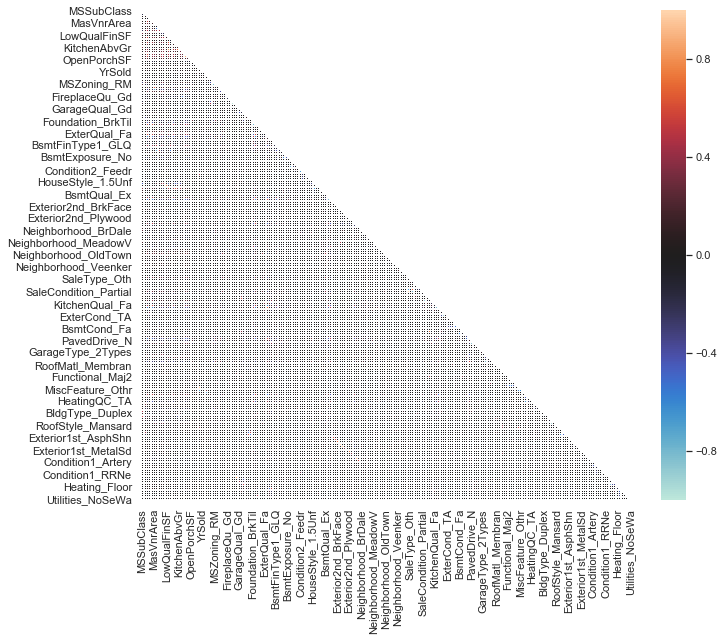

In [50]:
cols = X.columns
corr = X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=1, center=0,vmin=-1 , 
            square=True, linewidths=.005)

After One Hot Encoding, it is expectable to have many colinear variables. This is a special concern for later use of methods like Linear Regression. So, for that it is essential to use the flag 'fit_intercept=False'. To-Do: Adopt other measures to fight multicolinearity.

# Split Data

### Shuffle before split

In [51]:
l1=X.values.tolist()
l2=pd.DataFrame(Y).values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])
    
new_df=pd.DataFrame(l1,columns=X.columns.tolist()+pd.DataFrame(Y).columns.tolist())

new_df = shuffle(new_df, random_state=42)

In [52]:
testSize = 0.3 #we can try with different test_sizes

#dividing features that were not hotencoded for frther analysis of the feature importance for each classifier
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_not_encoded, Y, test_size = 0.2) 

train,test = train_test_split(new_df,test_size=testSize)

y_train = train['SalePrice']
X_train = train.drop('SalePrice',axis=1)
y_test = test['SalePrice']
X_test = test.drop('SalePrice',axis=1)

# Building Classifiers and Finding their Best Parameters
Just tuning the critial parameters, not all of them.
I intercalate between randomizedSearch and GridSearch to diversify and adjust accordingly to the number of parameters needed to test.

In [53]:
models = []
tree_classifiers = [] #useful to analyze SHAP values later
tuning_num_folds = 3
jobs=4
num_random_state=10
scoring_criteria='neg_mean_squared_error'
predictions = pd.DataFrame()

In [54]:
def permutation_importance(fittted_model, XTest, YTest):

    perm_model = PermutationImportance(fittted_model, random_state = num_random_state, cv = 'prefit', scoring="neg_mean_squared_error")
    perm_model.fit(XTest, YTest, scoring="neg_mean_squared_error")
    
    display(show_weights(perm_model, feature_names = list(XTest.columns)))

In [55]:
def check_fitting(model, name):
    
    plt.figure(figsize = (12,8))

    number_chunks = 20
    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, 
                                            train_sizes = np.linspace(0.01, 1.0, number_chunks), cv = 10, scoring = 'neg_mean_squared_error', 
                                            n_jobs = -1, random_state = 0)
    
    
    train_scores = pd.DataFrame(train_scores).multiply(-1).to_numpy()
    test_scores = pd.DataFrame(test_scores).multiply(-1).to_numpy()
    
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)  

    plt.plot(train_sizes, train_mean, '*-', color = 'blue',  label = 'Training score')
    plt.plot(train_sizes, test_mean, '*-', color = 'yellow', label = 'Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.1, color = 'b') # Alpha controls band transparency.
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.1, color = 'y')
    
    font_size = 12
    plt.xlabel('Training Set Size', fontsize = font_size)
    plt.ylabel('MSE Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')
    plt.grid()
    
    plt.suptitle('Check for Overfitting/Underfitting Issues of ' + name + ' When Submited to Different Training Sizes', fontsize = 15)
    plt.tight_layout(rect = [0, 0.03, 1, 0.97])
    Path("./results/house_prices/" + name).mkdir(parents=True, exist_ok=True)
    plt.grid()
    #saving the image
    plt.savefig('./results/house_prices/' + name + '/learning_curve.png')
    plt.show()

In [56]:
# It displays the scores of the combinations of the tunning parameters. It is useful, for example, to see if a parameter is really worth to wasting time to varying it by assess the impact that its variation has in the score
# It can only be applied when we use grid search because we know the combinations made,contrary to randomSearch
def display_tuning_scores(params, tunning):
    
    keys  = list(params.keys())
    lengths = [len(params[x]) for x in keys]
    if 1 in lengths:
        lengths.remove(1)
    lengths.sort(reverse=True)
    master_scores = tunning.cv_results_['mean_test_score']
    
    for length in lengths:
        for key, value in params.items():
            if len(value) == length:
                myKey = key
                break

        scores = np.array(master_scores).reshape(tuple(lengths))
        scores = [x.mean() for x in scores]
        scores = pd.Series(scores).mul(-1).tolist() # multiplied per -1 because we want to know the true mse
        
        plt.figure(figsize=(10,5))
        plt.plot(params[myKey],scores, '*-',)
        plt.xlabel(myKey)
        plt.ylabel('Mean score')
        plt.show()
        params.pop(myKey, None)
        lengths = lengths[1:] + [lengths[0]]

## Random Forest Regressor Tuning

In [57]:
name = 'Random Forest'
params = {'n_estimators' : [70,100], 'min_samples_split' : [3,4,6,10], 'random_state': [5] }


skf = KFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

#These two lines are useful to analyze SHAP values later
tree_classifiers.append(('Random Forest', RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'], min_samples_split=random_search.best_params_['min_samples_split'])))
tree_classifiers.append(('Random Forest', RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'], min_samples_split=random_search.best_params_['min_samples_split'])))

model_config_1 = RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'], min_samples_split=random_search.best_params_['min_samples_split'])
model_config_2 = RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'], min_samples_split=random_search.best_params_['min_samples_split'])
tunned_model = model_config_1.fit(X_train,y_train)
models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))    

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:   27.1s finished


Random Forest - Feature Importances


## Tuning Linear Regression

Linear Regression - Feature Importances


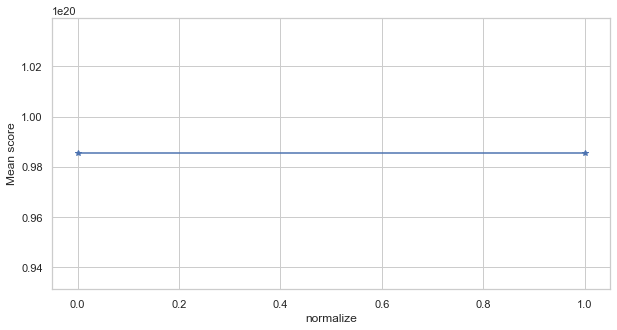

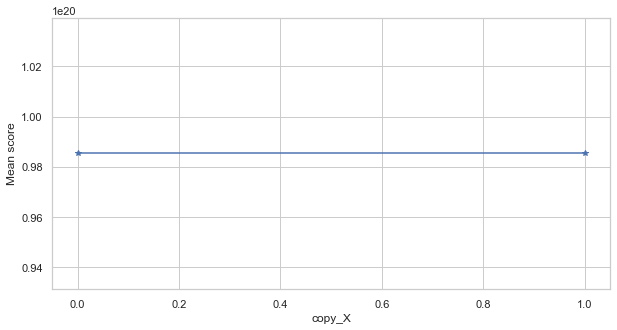

In [58]:
name = 'Linear Regression'

param = {'fit_intercept':[False], 'normalize':[True,False], 'copy_X':[True, False]}

grid = GridSearchCV(LinearRegression(), param,verbose=False, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = LinearRegression(fit_intercept=grid.best_params_['fit_intercept'], normalize=grid.best_params_['normalize'], copy_X=grid.best_params_['copy_X'])
model_config_2 = LinearRegression(fit_intercept=grid.best_params_['fit_intercept'], normalize=grid.best_params_['normalize'], copy_X=grid.best_params_['copy_X'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))    

## Ridge tuning

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:    1.9s finished


Ridge - Feature Importances


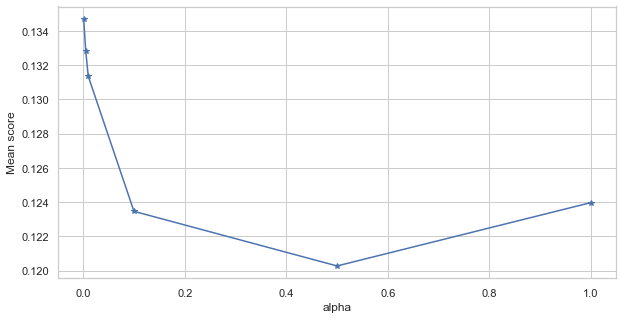

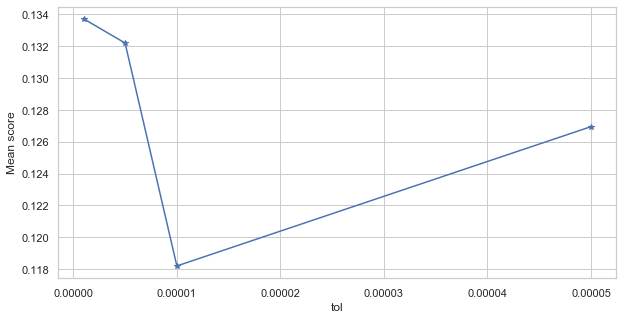

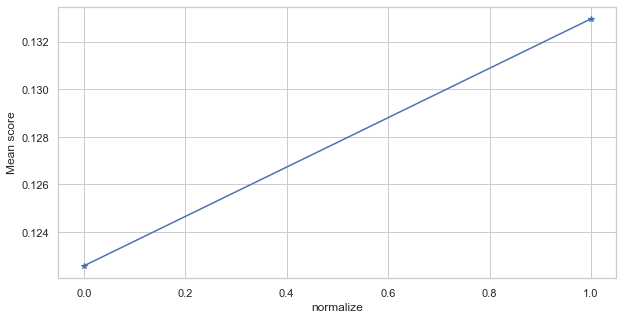

In [59]:
name = 'Ridge'

param = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}


grid = GridSearchCV(Ridge(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = Ridge(alpha=grid.best_params_['alpha'], normalize=grid.best_params_['normalize'], tol=grid.best_params_['tol'])
model_config_2 = Ridge(alpha=grid.best_params_['alpha'], normalize=grid.best_params_['normalize'], tol=grid.best_params_['tol'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))    

## Lasso tuning

In [60]:
name = 'Lasso'
params = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}


skf = KFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(Lasso(), param_distributions=params, scoring=scoring_criteria, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = Lasso(alpha=random_search.best_params_['alpha'], normalize=random_search.best_params_['normalize'], tol=random_search.best_params_['tol'])
model_config_2 = Lasso(alpha=random_search.best_params_['alpha'], normalize=random_search.best_params_['normalize'], tol=random_search.best_params_['tol'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))      

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.7s finished


Lasso - Feature Importances


## Elastic Net tuning

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:    1.3s finished


Elastic Net - Feature Importances


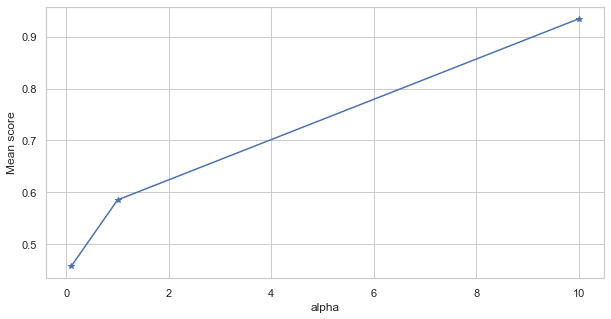

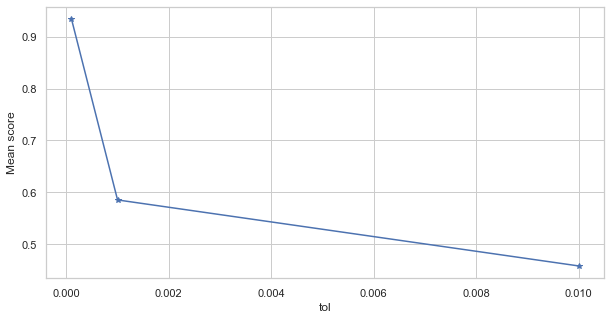

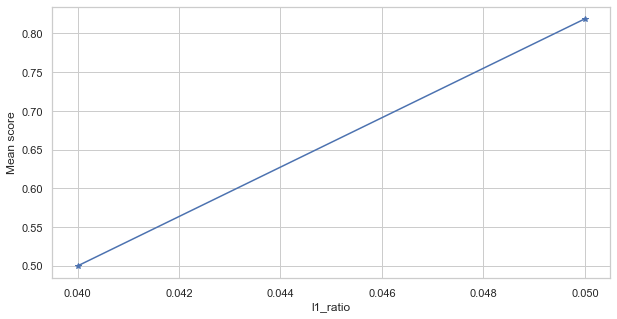

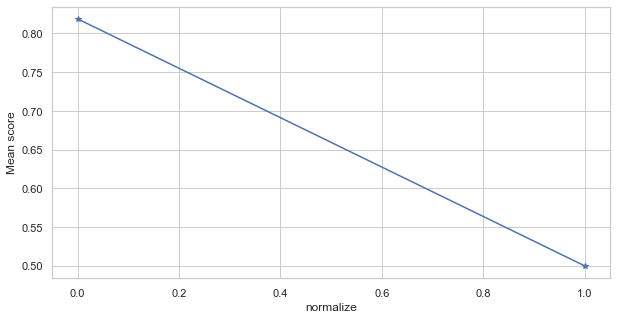

In [61]:
name = 'Elastic Net'

param={'alpha' :[0.1,1.0,10], 'l1_ratio':[0.04,0.05],'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}

grid = GridSearchCV(ElasticNet(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = ElasticNet(alpha=grid.best_params_['alpha'], l1_ratio=grid.best_params_['l1_ratio'], normalize=grid.best_params_['normalize'], tol=grid.best_params_['tol'])
model_config_2 = ElasticNet(alpha=grid.best_params_['alpha'], l1_ratio=grid.best_params_['l1_ratio'], normalize=grid.best_params_['normalize'], tol=grid.best_params_['tol'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))     

## DecisionTreeClassifier tuning

Since each split in the decision tree distinguishes the dependent variable, splits closer to the root, aka starting point, have optimally been determined to have the greatest splitting effect. The feature importance graphic measures how much splitting impact each feature has. It is important to note that this by no means points to causality, but just like in hierarchical clustering, does point to a nebulous groups. Furthermore, for ensemble tree methods, feature impact is aggregated over all the trees.

In [62]:
name = 'DT'
param = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14], 'max_leaf_nodes' : [None, 12,15,18,20] }

grid = GridSearchCV(DecisionTreeRegressor(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 193 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:    1.8s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=10, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': [7, 8, 9, 10],
                         'max_features': [11,

In [63]:
"""
# Helper Function to visualize feature importance if needed
plt.rcParams['figure.figsize'] = (8, 4)
predictors = [x for x in X.columns]
def feature_imp(model):
    MO = model.fit(X_train, y_train)
    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
"""


"\n# Helper Function to visualize feature importance if needed\nplt.rcParams['figure.figsize'] = (8, 4)\npredictors = [x for x in X.columns]\ndef feature_imp(model):\n    MO = model.fit(X_train, y_train)\n    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)\n    feat_imp.plot(kind='bar', title='Feature Importances')\n    plt.ylabel('Feature Importance Score')\n"

**Pruning the decision trees**

Adapted from [here](https://stackoverflow.com/questions/49428469/pruning-decision-trees)

In [64]:
"""traverse the tree and remove all children of the nodes with minimum class count less than 5  (or any other condition you can think of)."""
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)



DT - Feature Importances


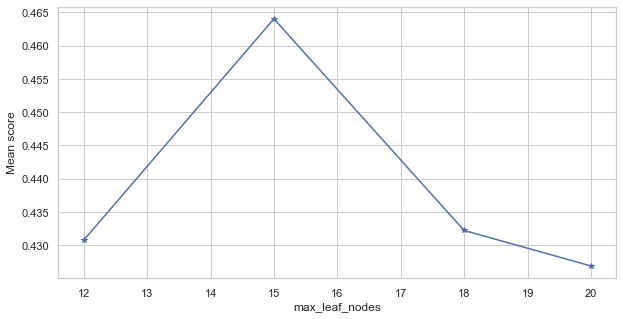

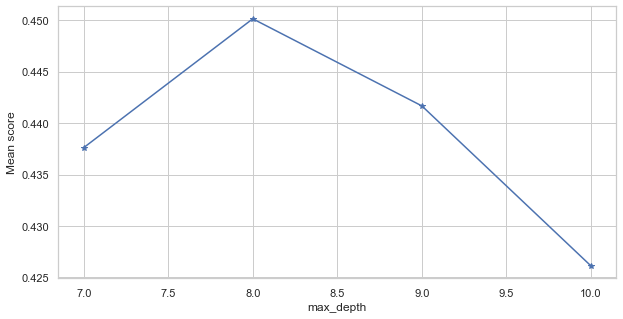

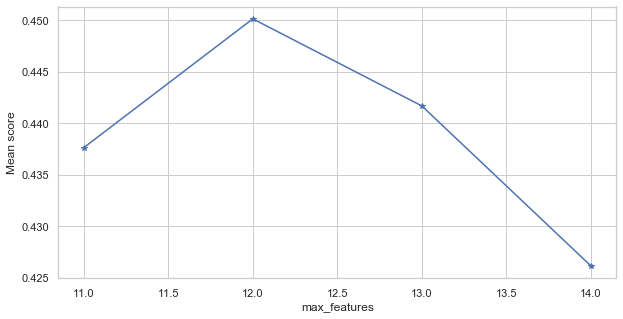

In [65]:
#These two lines are useful to analyze SHAP values later
tree_classifiers.append(('DT', DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], max_leaf_nodes=grid.best_params_['max_leaf_nodes'])))
tree_classifiers.append(('DT', DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], max_leaf_nodes=grid.best_params_['max_leaf_nodes'])))

model_config_1 = DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], max_leaf_nodes=grid.best_params_['max_leaf_nodes'])
model_config_2 = DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], max_leaf_nodes=grid.best_params_['max_leaf_nodes'])
tunned_model = model_config_1.fit(X_train,y_train)

prune_index(tunned_model.tree_, 0, 5)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))    

## SVR tuning

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  2.3min finished


SVR - Feature Importances


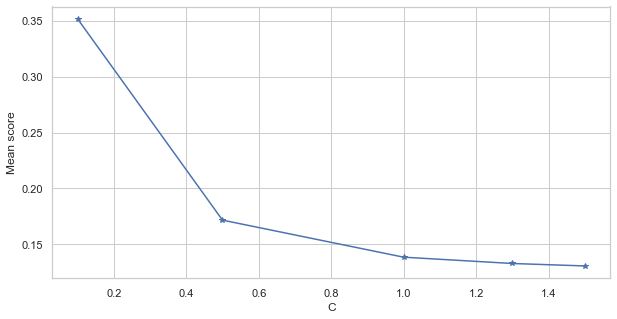

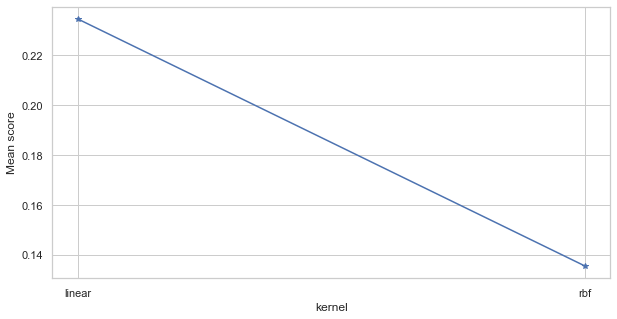

In [66]:
name = 'SVR'
param={'C':[0.1,0.5, 1,1.3,1.5],
      'kernel': ["linear","rbf"]
      }

grid = GridSearchCV(SVR(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = SVR(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
model_config_2 = SVR(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

### KNN Regressor tuning

In [67]:
name = 'KNN'
params ={'n_neighbors' : [3,5,10],  
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['brute']}

random_search = RandomizedSearchCV(KNeighborsRegressor(), param_distributions=params, scoring=scoring_criteria, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = KNeighborsRegressor(n_neighbors=random_search.best_params_['n_neighbors'], weights=random_search.best_params_['weights'], algorithm=random_search.best_params_['algorithm'])
model_config_2 = KNeighborsRegressor(n_neighbors=random_search.best_params_['n_neighbors'], weights=random_search.best_params_['weights'], algorithm=random_search.best_params_['algorithm'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    0.4s finished


KNN - Feature Importances


### Gaussian Process Tuning

In [68]:
name = 'Gaussian'
param = {'normalize_y' : [True,False],
              'kernel' : [DotProduct(), ConstantKernel(1.0, (1e-3, 1e3))] }

grid = GridSearchCV(GaussianProcessRegressor(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = GaussianProcessRegressor(normalize_y=grid.best_params_['normalize_y'], kernel=grid.best_params_['kernel'])
model_config_2 = GaussianProcessRegressor(normalize_y=grid.best_params_['normalize_y'], kernel=grid.best_params_['kernel'])

tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   13.1s finished


Gaussian - Feature Importances


## Boosting

### GradientBoostingClassifier tuning

In [69]:
name = 'GraBoost'
param_grid ={
            'n_estimators': [5,10,15,20,25],
            'max_depth': [5,7,10],
            'learning_rate' : [0.01,0.1,1,10]
            }

random_search = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_grid, scoring=scoring_criteria, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = GradientBoostingRegressor(n_estimators=random_search.best_params_['n_estimators'], max_depth=random_search.best_params_['max_depth'], learning_rate=random_search.best_params_['learning_rate'], verbose=0)
model_config_2 = GradientBoostingRegressor(n_estimators=random_search.best_params_['n_estimators'], max_depth=random_search.best_params_['max_depth'], learning_rate=random_search.best_params_['learning_rate'], verbose=0)
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.8s finished


GraBoost - Feature Importances


### XGB Regressor Tuning

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   21.3s finished


XGB - Learning Curve


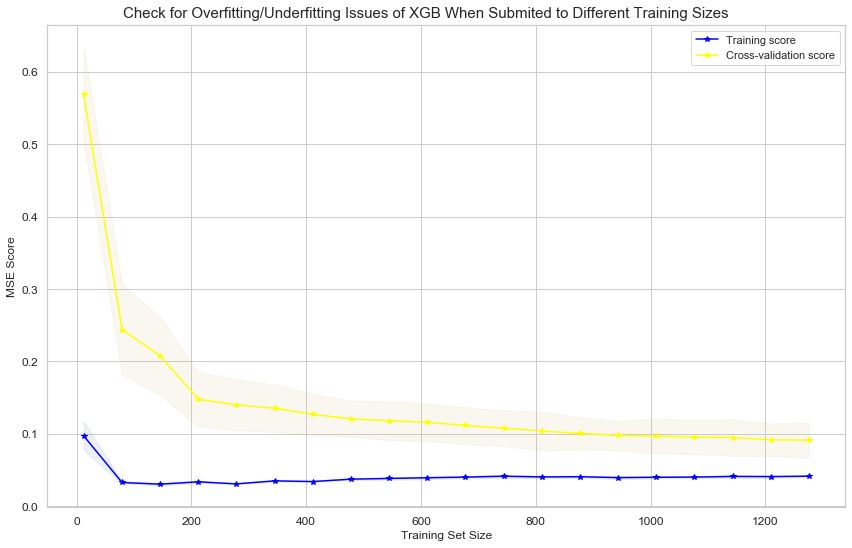

XGB - Feature Importances


In [70]:
name = 'XGB'
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],'max_depth': [2,3,4]}


skf = KFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(XGBRegressor(), param_distributions=params, scoring=scoring_criteria, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = XGBRegressor(min_child_weight=random_search.best_params_['min_child_weight'],gamma=random_search.best_params_['gamma'], max_depth=random_search.best_params_['max_depth'], verbose=0)
model_config_2 = XGBRegressor(min_child_weight=random_search.best_params_['min_child_weight'],gamma=random_search.best_params_['gamma'], max_depth=random_search.best_params_['max_depth'], verbose=0)
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

print(name + " - Learning Curve")
check_fitting(model_config_2, name)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

### Catboost Process Tuning

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:  2.5min finished


0:	learn: 0.9491070	total: 57.2ms	remaining: 11.4s
1:	learn: 0.8957705	total: 63.7ms	remaining: 6.3s
2:	learn: 0.8442920	total: 70.2ms	remaining: 4.61s
3:	learn: 0.7962509	total: 76.7ms	remaining: 3.76s
4:	learn: 0.7544461	total: 86ms	remaining: 3.35s
5:	learn: 0.7184987	total: 98.1ms	remaining: 3.17s
6:	learn: 0.6844419	total: 109ms	remaining: 3s
7:	learn: 0.6560096	total: 118ms	remaining: 2.83s
8:	learn: 0.6257093	total: 138ms	remaining: 2.93s
9:	learn: 0.5983065	total: 147ms	remaining: 2.79s
10:	learn: 0.5713419	total: 179ms	remaining: 3.08s
11:	learn: 0.5465833	total: 187ms	remaining: 2.93s
12:	learn: 0.5237997	total: 195ms	remaining: 2.8s
13:	learn: 0.5043018	total: 202ms	remaining: 2.68s
14:	learn: 0.4861636	total: 208ms	remaining: 2.57s
15:	learn: 0.4693708	total: 218ms	remaining: 2.5s
16:	learn: 0.4538812	total: 226ms	remaining: 2.43s
17:	learn: 0.4414043	total: 237ms	remaining: 2.4s
18:	learn: 0.4309920	total: 254ms	remaining: 2.42s
19:	learn: 0.4199636	total: 267ms	remaining:

172:	learn: 0.1852628	total: 1.23s	remaining: 193ms
173:	learn: 0.1848412	total: 1.24s	remaining: 185ms
174:	learn: 0.1841463	total: 1.25s	remaining: 178ms
175:	learn: 0.1835477	total: 1.25s	remaining: 171ms
176:	learn: 0.1831447	total: 1.26s	remaining: 164ms
177:	learn: 0.1826311	total: 1.26s	remaining: 156ms
178:	learn: 0.1822944	total: 1.27s	remaining: 149ms
179:	learn: 0.1815813	total: 1.27s	remaining: 142ms
180:	learn: 0.1814366	total: 1.28s	remaining: 135ms
181:	learn: 0.1809942	total: 1.29s	remaining: 127ms
182:	learn: 0.1801924	total: 1.29s	remaining: 120ms
183:	learn: 0.1795659	total: 1.3s	remaining: 113ms
184:	learn: 0.1794652	total: 1.3s	remaining: 106ms
185:	learn: 0.1786456	total: 1.31s	remaining: 98.5ms
186:	learn: 0.1783027	total: 1.31s	remaining: 91.3ms
187:	learn: 0.1781246	total: 1.32s	remaining: 84.2ms
188:	learn: 0.1775972	total: 1.32s	remaining: 77.1ms
189:	learn: 0.1772553	total: 1.33s	remaining: 70ms
190:	learn: 0.1770537	total: 1.33s	remaining: 62.9ms
191:	learn

160:	learn: 0.1887060	total: 1.02s	remaining: 246ms
161:	learn: 0.1886161	total: 1.02s	remaining: 240ms
162:	learn: 0.1880808	total: 1.03s	remaining: 233ms
163:	learn: 0.1877638	total: 1.03s	remaining: 227ms
164:	learn: 0.1872817	total: 1.04s	remaining: 221ms
165:	learn: 0.1871352	total: 1.05s	remaining: 214ms
166:	learn: 0.1870726	total: 1.05s	remaining: 208ms
167:	learn: 0.1869076	total: 1.06s	remaining: 201ms
168:	learn: 0.1865616	total: 1.06s	remaining: 195ms
169:	learn: 0.1864028	total: 1.07s	remaining: 188ms
170:	learn: 0.1858995	total: 1.07s	remaining: 182ms
171:	learn: 0.1858198	total: 1.07s	remaining: 175ms
172:	learn: 0.1852628	total: 1.08s	remaining: 169ms
173:	learn: 0.1848412	total: 1.08s	remaining: 162ms
174:	learn: 0.1841463	total: 1.09s	remaining: 156ms
175:	learn: 0.1835477	total: 1.1s	remaining: 150ms
176:	learn: 0.1831447	total: 1.1s	remaining: 143ms
177:	learn: 0.1826311	total: 1.11s	remaining: 137ms
178:	learn: 0.1822944	total: 1.11s	remaining: 131ms
179:	learn: 0.

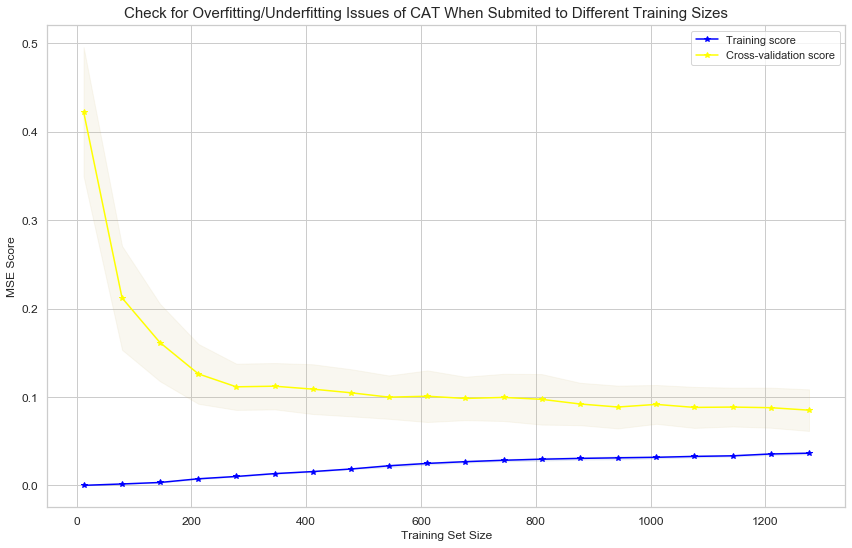

CAT - Feature Importances
0:	learn: 0.9472113	total: 4.46ms	remaining: 889ms
1:	learn: 0.8937779	total: 7.46ms	remaining: 739ms
2:	learn: 0.8461967	total: 10.3ms	remaining: 675ms
3:	learn: 0.7987753	total: 13.1ms	remaining: 641ms
4:	learn: 0.7538105	total: 17ms	remaining: 665ms
5:	learn: 0.7145605	total: 20.6ms	remaining: 667ms
6:	learn: 0.6829308	total: 25ms	remaining: 688ms
7:	learn: 0.6532684	total: 28.6ms	remaining: 687ms
8:	learn: 0.6222346	total: 31.7ms	remaining: 673ms
9:	learn: 0.5944785	total: 34.8ms	remaining: 661ms
10:	learn: 0.5699776	total: 38.4ms	remaining: 659ms
11:	learn: 0.5486898	total: 41.2ms	remaining: 645ms
12:	learn: 0.5285748	total: 44.1ms	remaining: 634ms
13:	learn: 0.5094533	total: 47ms	remaining: 624ms
14:	learn: 0.4917906	total: 49.7ms	remaining: 614ms
15:	learn: 0.4738564	total: 52.9ms	remaining: 608ms
16:	learn: 0.4584582	total: 62.5ms	remaining: 672ms
17:	learn: 0.4457001	total: 65.3ms	remaining: 660ms
18:	learn: 0.4333053	total: 68.1ms	remaining: 649ms
19

181:	learn: 0.1886409	total: 593ms	remaining: 58.7ms
182:	learn: 0.1878213	total: 597ms	remaining: 55.4ms
183:	learn: 0.1875234	total: 600ms	remaining: 52.2ms
184:	learn: 0.1869941	total: 603ms	remaining: 48.9ms
185:	learn: 0.1868160	total: 607ms	remaining: 45.7ms
186:	learn: 0.1867272	total: 611ms	remaining: 42.4ms
187:	learn: 0.1863299	total: 614ms	remaining: 39.2ms
188:	learn: 0.1859179	total: 618ms	remaining: 36ms
189:	learn: 0.1857797	total: 621ms	remaining: 32.7ms
190:	learn: 0.1854828	total: 624ms	remaining: 29.4ms
191:	learn: 0.1850952	total: 627ms	remaining: 26.1ms
192:	learn: 0.1846235	total: 630ms	remaining: 22.9ms
193:	learn: 0.1845012	total: 633ms	remaining: 19.6ms
194:	learn: 0.1842820	total: 636ms	remaining: 16.3ms
195:	learn: 0.1838853	total: 639ms	remaining: 13ms
196:	learn: 0.1833960	total: 641ms	remaining: 9.77ms
197:	learn: 0.1829217	total: 645ms	remaining: 6.51ms
198:	learn: 0.1824366	total: 648ms	remaining: 3.25ms
199:	learn: 0.1820581	total: 650ms	remaining: 0us


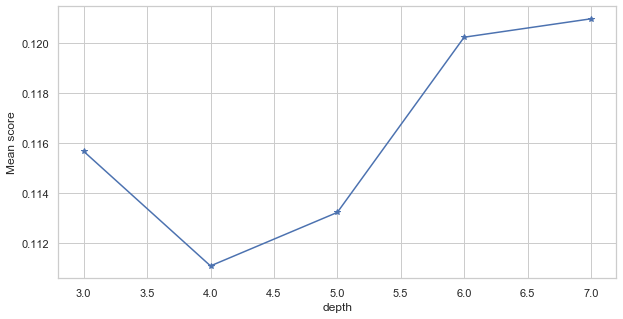

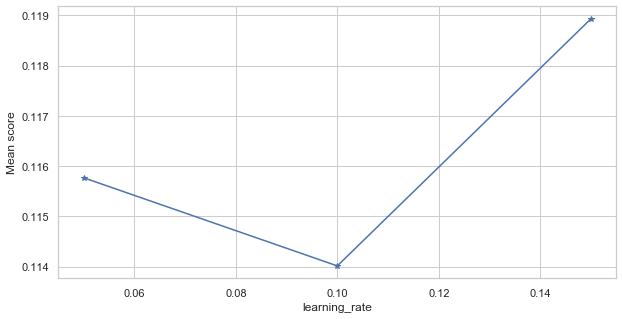

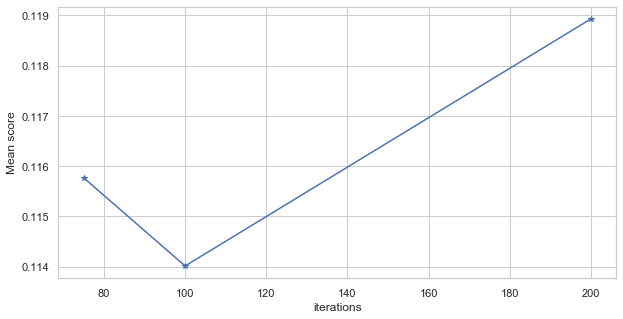

In [71]:
name = 'CAT'
param = {'depth': [3,4,5,6,7],
                'learning_rate': [0.05,0.1,0.15],
                'iterations': [75,100,200]}
grid = GridSearchCV(CatBoostRegressor(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = CatBoostRegressor(depth=grid.best_params_['depth'], learning_rate=grid.best_params_['learning_rate'], iterations=grid.best_params_['iterations'])
model_config_2 = CatBoostRegressor(depth=grid.best_params_['depth'], learning_rate=grid.best_params_['learning_rate'], iterations=grid.best_params_['iterations'])

tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

print(name + " - Learning Curve")
check_fitting(model_config_2, name)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

## Ensemble Methods

**Studying Correlation**
If base models' predictions are weakly correlated with each other, the ensemble will likely to perform better. On the other hand, for a strong correlation of predictions among the base models, the ensemble will unlikely to perform better. 

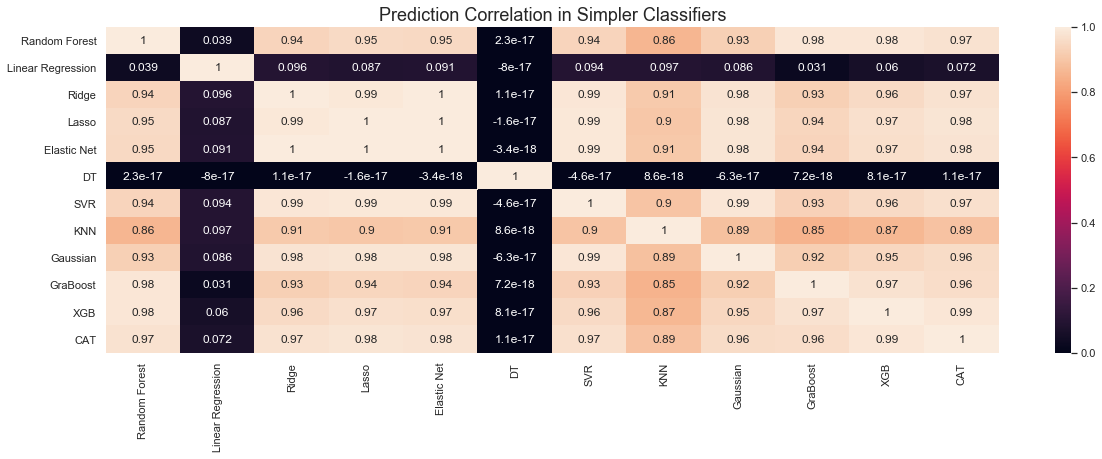

In [72]:
plt.figure(figsize = (20, 6))
correlations = predictions.corr()
sns.heatmap(correlations, annot = True)
plt.title('Prediction Correlation in Simpler Classifiers', fontsize = 18)
plt.show()

**As we can see, there are some classifiers that have a high correlated predictions. So, we won't use them to form the ensemble models.**

In [73]:
classifiers = copy.deepcopy(models)
every_model = copy.deepcopy(models)

for i in range(0, len(correlations.columns)):
    for j in range(0, len(correlations.columns)):
        if j>=i:
            break
        else:
            if abs(correlations.iloc[i,j]) >= 0.85:
                for index, clf in enumerate(classifiers):
                    if correlations.columns[j] == clf[0]:
                        del classifiers[index]
                
classifiers = [i[1] for i in classifiers]

### Voting

In [74]:
def voting(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    copy_1 = average_results[average_results.Model.isin([i[0] for i in models])]
    copy_1.sort_values(by=["Test MSE"], ascending=True, inplace=True)

    numb_voters = np.arange(2,len(classifiers)+1,1)

    #we we'll try to ensemble the best two classifiers, then the best three, the best, four, etc
    for i in numb_voters:
        models_names = list(copy_1.iloc[0:i,0])
        voting_models = []
        for model1 in models_names:
            for model2 in models:
                if model2[0] == model1:
                    voting_models.append(model2)

        model_config_1 = VotingRegressor(voting_models) 
        model_config_2 = VotingRegressor(voting_models) 
        model = model_config_1.fit(X_train,Y_train)

        name = "Voter_" + str(i) + "_best"

        #Analyze feature importance of Original Data
        print(name + " - Feature Importances")
        permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)
        
        every_model.append((name, model))
        pickle.dump(model, open('./models/house_prices/' + name + '_model.sav', 'wb'))
        average_results,models_test_mses, models_train_mses, models_validation_mses = classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)

    return average_results,models_test_mses, models_train_mses, models_validation_mses

### Bagging (Bootstrapping Aggregation)

Bagging is characteristic of random forest. You bootstrap or subdivide the same training set into multiple subsets or bags. This steps is also called row sampling with replacement. Each of these training bags will feed a mmodel to be trained. After each model being trained, it is time for aggragation, in other orders, to predict the outcome based on a voting system of each model trained.

In [75]:
def bagging(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):

    random_forest_regressor = RandomForestRegressor() # is the random forest classifier

    model_config_1 = BaggingRegressor(base_estimator = random_forest_regressor, verbose = 0, n_jobs = -1, random_state = seed)
    model_config_2 = BaggingRegressor(base_estimator = random_forest_regressor, verbose = 0, n_jobs = -1, random_state = seed)
    
    model = model_config_1.fit(X_train, Y_train)
    name = "bagging"
    
    #Analyze feature importance of Original Data
    print(name + " - Feature Importances")
    permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)
    
    every_model.append((name, model))
    pickle.dump(model, open('./models/house_prices/' + name + '_model.sav', 'wb'))
    
    return classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)
    
    

### Blending

In [76]:
def blending(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    
    copy_2 = average_results[average_results.Model.isin([i[0] for i in models])]
    copy_2.sort_values(by=["Test MSE"], ascending=True, inplace=True)

    numb_voters = np.arange(2,len(classifiers)+1,1)

    #we we'll try to ensemble the best two classifiers, then the best three, the best, four, etc
    for i in numb_voters:
        models_names = list(copy_2.iloc[0:i,0])
        blending_models = []
        for model1 in models_names:
            for model2 in models:
                if model2[0] == model1:
                    blending_models.append(model2[1])

        blend_1 = BlendEnsemble(n_jobs = -1, test_size = 0.5, random_state = seed, scorer="accuracy")
        blend_1.add(blending_models) 
        blend_1.add_meta(RandomForestRegressor())

        blend_2 = BlendEnsemble(n_jobs = -1, test_size = 0.5, random_state = seed)
        blend_2.add(blending_models) #proba=true s important in order to predict_proba function properly later
        blend_2.add_meta(RandomForestRegressor())

        model = blend_1.fit(X_train, Y_train, scoring=scoring_criteria)
        name = "blending_" + str(i) + "_best"

        #Analyze feature importance of Original Data
        print(name + " - Feature Importances")
        permutation_importance(blend_2.fit(X_original_train,y_original_train, scoring="accuracy"), X_original_test, y_original_test)
        
        every_model.append((name, model))
        pickle.dump(model, open('./models/house_prices/' + name + '_model.sav', 'wb'))

        average_results,models_test_mses, models_train_mses, models_validation_mses = classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)

        
    return average_results,models_test_mses, models_train_mses, models_validation_mses


### Stacking

Shortly, we are trying to fit a model upon Y_valid data and models' predictions (stacked) made during the validation stage. Then, we will try to predict from the models' predictions (stacked) of test data to see if we reach Y_test values.

In this model we can't analyze the true feature importance because all the features that matter are the predictions of the classifiers!

In [77]:
def stacking_function(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    numb_voters = np.arange(2,len(classifiers)+1, 1)

    S_train, S_test = stacking(classifiers, X_train, Y_train, X_test, regression = True, mode = 'oof_pred_bag', needs_proba = False, save_dir = None,metric = accuracy_score, n_folds = num_folds, shuffle = True, random_state =  seed, verbose = 0)                

    super_learner = RandomForestRegressor()
    model_1 = super_learner.fit(S_train, Y_train)
    name = "stacking"
    
    every_model.append((name, model_1))
    pickle.dump(model_1, open('./models/house_prices/' + name + '_model.sav', 'wb'))
    
    return classify_performance(name, model_1, S_train, S_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)


# Runs
**First of all, we'll execute 30 tests of cross-validation of all the models but with different seeds.**

In [78]:
def classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses):

    cv_results = cross_validate(model, X_train, Y_train, cv=num_folds, scoring=scoring, verbose=0, return_train_score=True)
    
    if (seed==0):
        print(name + " - Learning Curve")
        check_fitting(model, name)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)
    rmse = mean_squared_error(Y_test, y_pred, squared=False)
    r2 = r2_score(Y_test, y_pred)
    
    print("%s - Train: MSE - %.3f, MAE: %.3f, RMSE: %.3f. , R2: %.3f." % (name, cv_results['train_MSE'].mean(), cv_results['train_MAE'].mean(), cv_results['train_RMSE'].mean(), cv_results['train_R2'].mean()))
    print("%s - Test: MSE - %.3f, MAE: %.3f, RMSE: %.3f. , R2: %.3f." % (name, mse, mae,rmse, r2))

    new_entry = {'Model': name,
                'Test MSE': mse,
                'Test MAE': mae,
                'Test RMSE': rmse,
                'Test R2': r2,
                'Train MSE':cv_results['train_MSE'].mean(),
                'Train MAE':cv_results['train_MAE'].mean(),
                'Train RMSE':cv_results['train_RMSE'].mean(),
                'Train R2':cv_results['train_R2'].mean(),              
                'Validation MSE':cv_results['test_MSE'].mean(),
                'Validation MAE':cv_results['test_MAE'].mean(),
                'Validation RMSE':cv_results['test_RMSE'].mean(),
                'Validation R2':cv_results['test_R2'].mean(),
                }

  
    for key, value in new_entry.items():
        if key != 'Model':
            average_results.iloc[average_results.ix[average_results['Model'] == name].index.values.astype(int)[0]][key] = float(average_results.ix[average_results['Model'] == name][key].values) + value

            models_test_mses.iloc[seed, :][name] = mse
            models_train_mses.iloc[seed, :][name] = cv_results['train_MSE'].mean()
            models_validation_mses.iloc[seed, :][name] = cv_results['test_MSE'].mean()
    
    return average_results, models_test_mses, models_train_mses, models_validation_mses



------------------------------- EXPERIMENT 1 ------------------------------------
Random Forest - Learning Curve


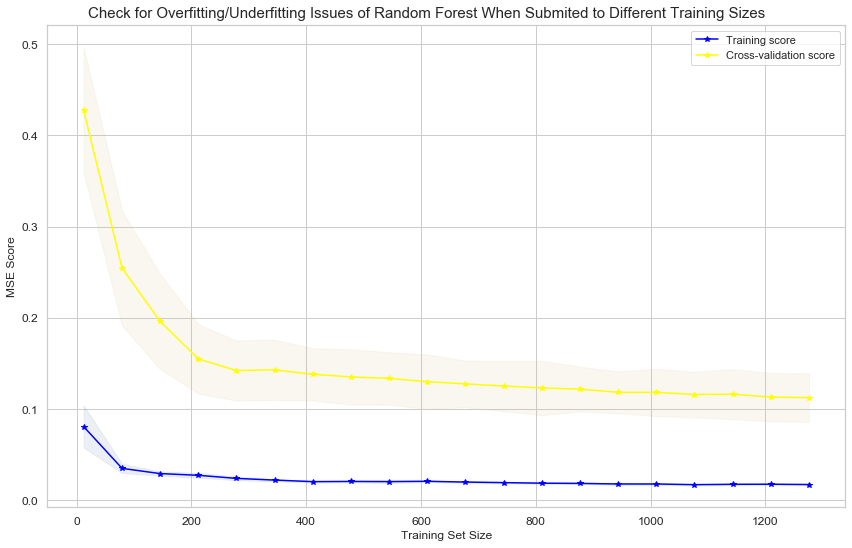

Random Forest - Train: MSE - -0.018, MAE: -0.089, RMSE: -0.135. , R2: 0.981.
Random Forest - Test: MSE - 0.054, MAE: 0.133, RMSE: 0.232. , R2: 0.954.
Linear Regression - Learning Curve


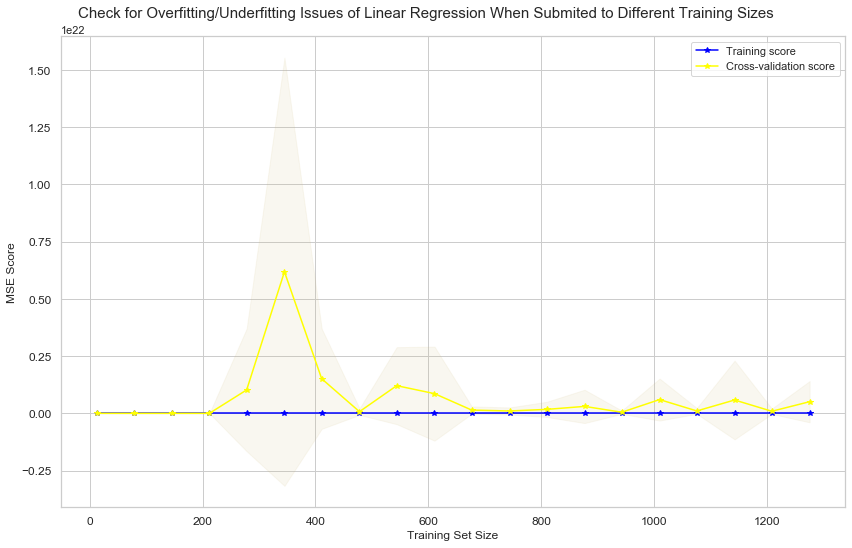

Linear Regression - Train: MSE - -0.049, MAE: -0.158, RMSE: -0.221. , R2: 0.948.
Linear Regression - Test: MSE - 123987300883488129024.000, MAE: 590982235.505, RMSE: 11134958503.896. , R2: -105374068027478687744.000.
Ridge - Learning Curve


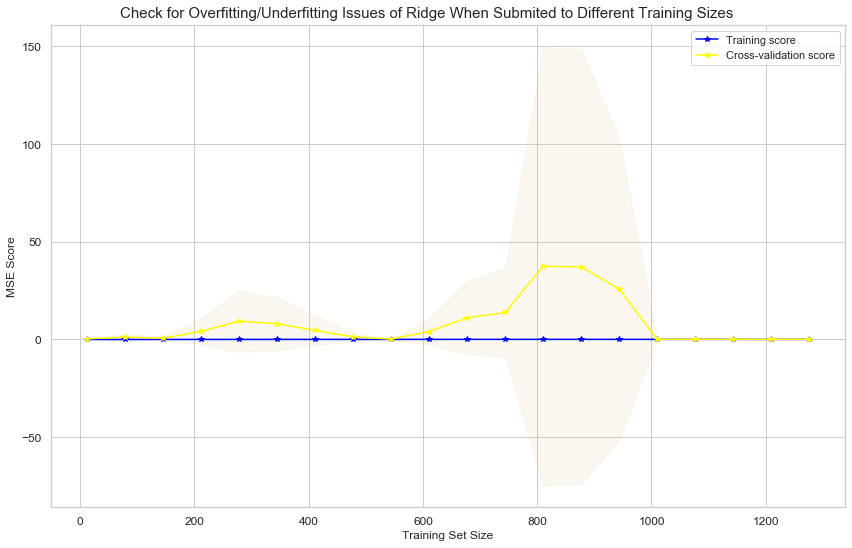

Ridge - Train: MSE - -0.066, MAE: -0.177, RMSE: -0.257. , R2: 0.930.
Ridge - Test: MSE - 0.092, MAE: 0.190, RMSE: 0.304. , R2: 0.922.
Lasso - Learning Curve


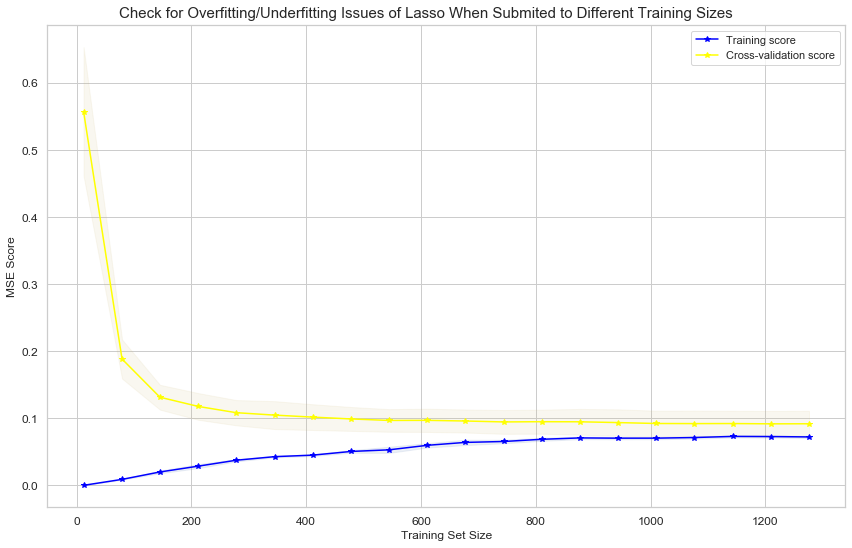

Lasso - Train: MSE - -0.063, MAE: -0.177, RMSE: -0.251. , R2: 0.933.
Lasso - Test: MSE - 0.086, MAE: 0.187, RMSE: 0.294. , R2: 0.926.
Elastic Net - Learning Curve


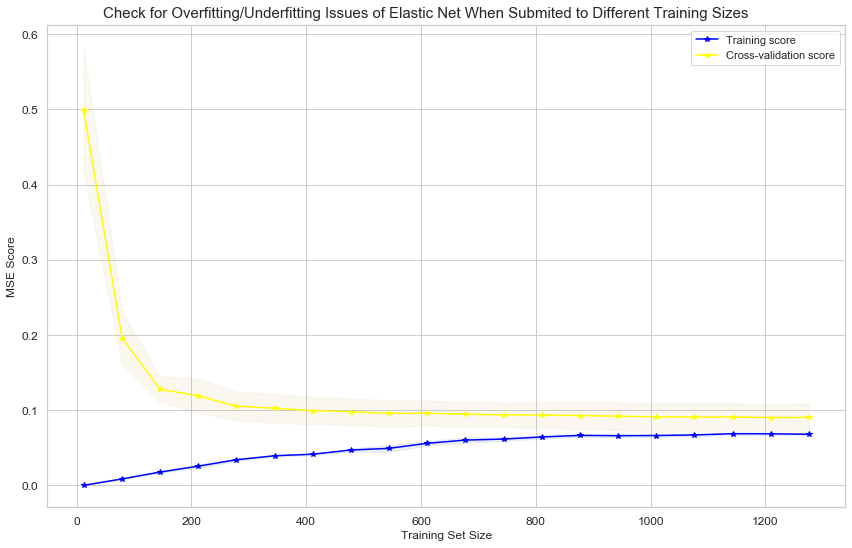

Elastic Net - Train: MSE - -0.059, MAE: -0.170, RMSE: -0.243. , R2: 0.937.
Elastic Net - Test: MSE - 0.080, MAE: 0.178, RMSE: 0.284. , R2: 0.932.
DT - Learning Curve


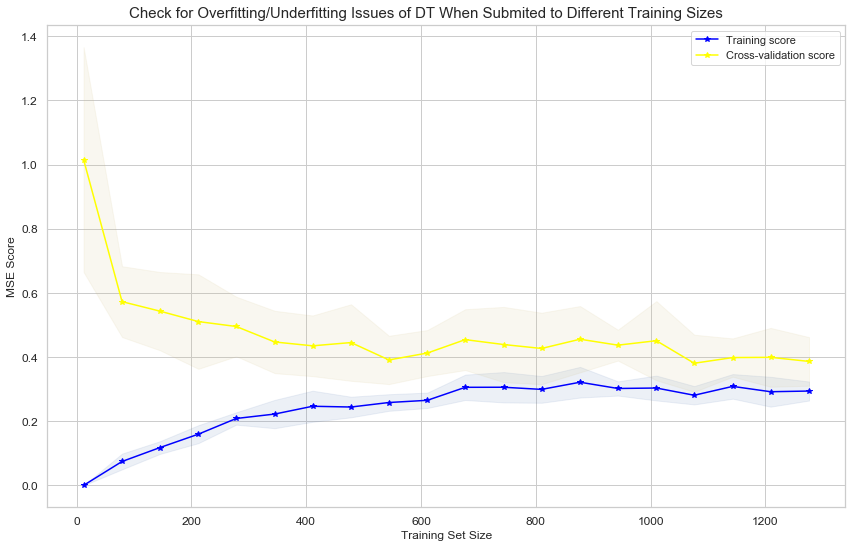

DT - Train: MSE - -0.297, MAE: -0.402, RMSE: -0.544. , R2: 0.684.
DT - Test: MSE - 1.177, MAE: 0.798, RMSE: 1.085. , R2: -0.000.
SVR - Learning Curve


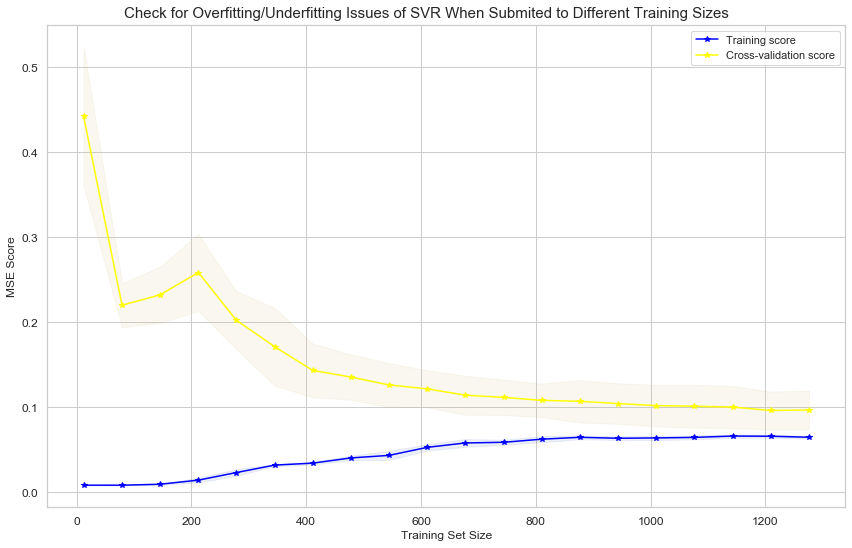

SVR - Train: MSE - -0.055, MAE: -0.157, RMSE: -0.234. , R2: 0.942.
SVR - Test: MSE - 0.078, MAE: 0.168, RMSE: 0.280. , R2: 0.933.
KNN - Learning Curve


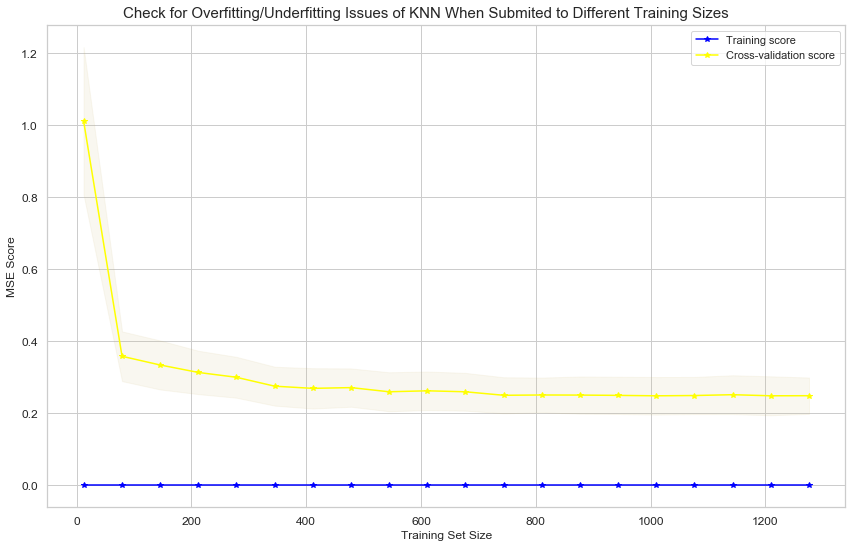

KNN - Train: MSE - -0.000, MAE: -0.000, RMSE: -0.000. , R2: 1.000.
KNN - Test: MSE - 0.063, MAE: 0.089, RMSE: 0.251. , R2: 0.946.
Gaussian - Learning Curve


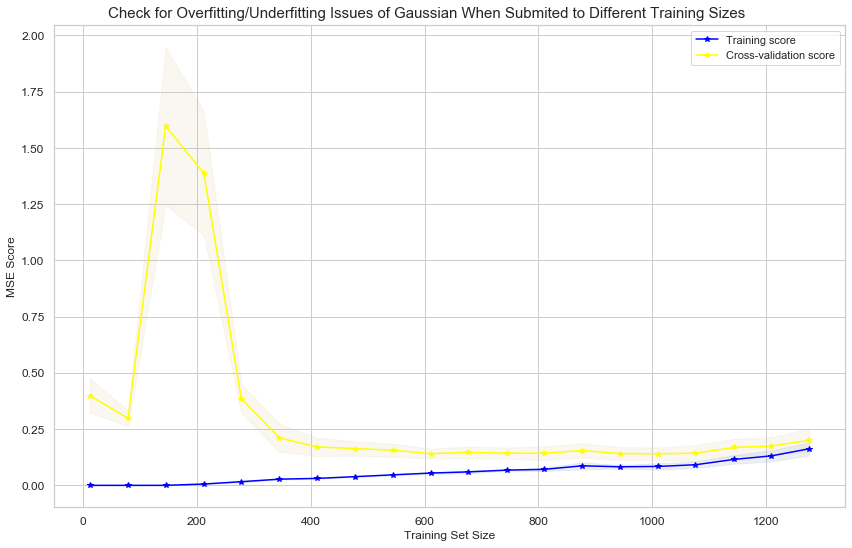

Gaussian - Train: MSE - -0.066, MAE: -0.195, RMSE: -0.257. , R2: 0.929.
Gaussian - Test: MSE - 0.090, MAE: 0.207, RMSE: 0.299. , R2: 0.924.
GraBoost - Learning Curve


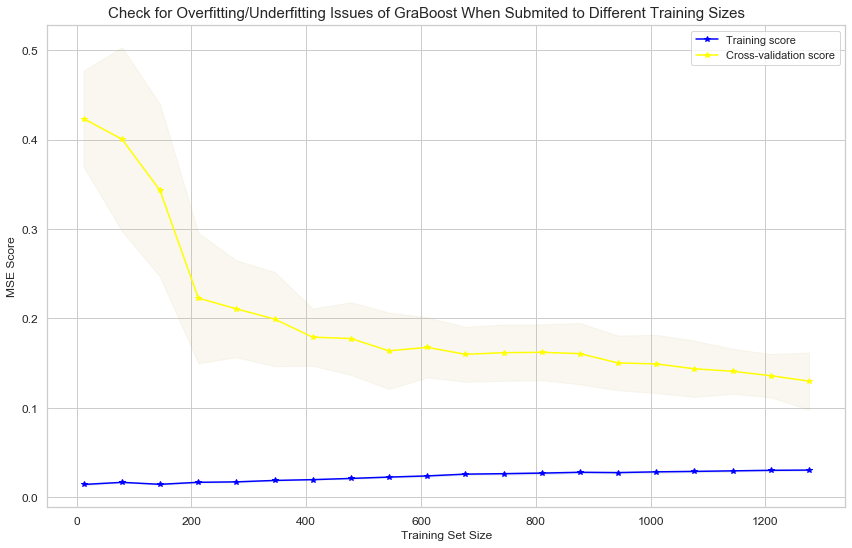

GraBoost - Train: MSE - -0.024, MAE: -0.121, RMSE: -0.155. , R2: 0.974.
GraBoost - Test: MSE - 0.057, MAE: 0.166, RMSE: 0.239. , R2: 0.951.
XGB - Learning Curve


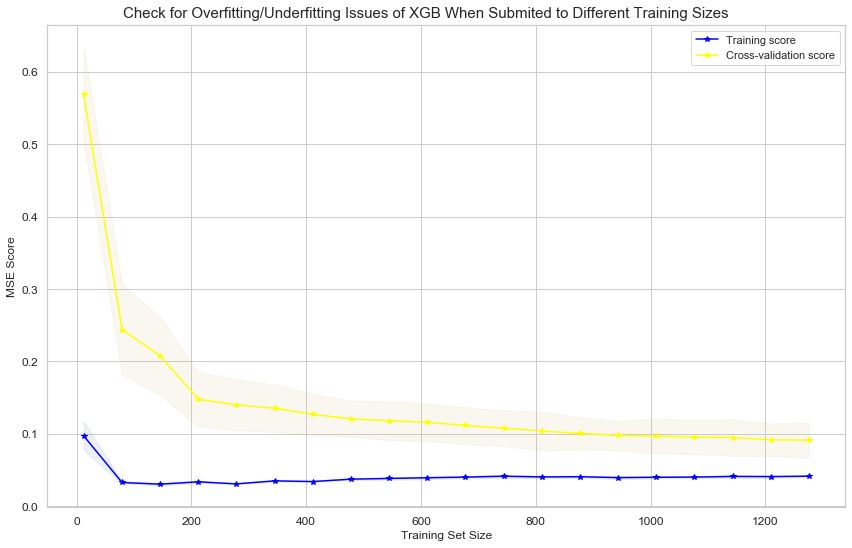

XGB - Train: MSE - -0.037, MAE: -0.142, RMSE: -0.193. , R2: 0.960.
XGB - Test: MSE - 0.057, MAE: 0.162, RMSE: 0.239. , R2: 0.951.
0:	learn: 0.9274704	total: 9.28ms	remaining: 1.85s
1:	learn: 0.8794259	total: 13ms	remaining: 1.29s
2:	learn: 0.8256097	total: 16.6ms	remaining: 1.09s
3:	learn: 0.7818470	total: 20.2ms	remaining: 989ms
4:	learn: 0.7442130	total: 26.4ms	remaining: 1.03s
5:	learn: 0.7012280	total: 31.7ms	remaining: 1.02s
6:	learn: 0.6660952	total: 35.5ms	remaining: 978ms
7:	learn: 0.6340473	total: 39.1ms	remaining: 938ms
8:	learn: 0.6081874	total: 43.1ms	remaining: 916ms
9:	learn: 0.5823969	total: 46.8ms	remaining: 889ms
10:	learn: 0.5582258	total: 50.8ms	remaining: 873ms
11:	learn: 0.5350850	total: 74.1ms	remaining: 1.16s
12:	learn: 0.5165563	total: 78.1ms	remaining: 1.12s
13:	learn: 0.4973903	total: 88.1ms	remaining: 1.17s
14:	learn: 0.4822335	total: 91.6ms	remaining: 1.13s
15:	learn: 0.4697981	total: 95.1ms	remaining: 1.09s
16:	learn: 0.4574430	total: 98.7ms	remaining: 1.06

176:	learn: 0.1743027	total: 1.31s	remaining: 170ms
177:	learn: 0.1737828	total: 1.31s	remaining: 162ms
178:	learn: 0.1734183	total: 1.32s	remaining: 155ms
179:	learn: 0.1733409	total: 1.34s	remaining: 149ms
180:	learn: 0.1725041	total: 1.35s	remaining: 141ms
181:	learn: 0.1721578	total: 1.35s	remaining: 134ms
182:	learn: 0.1718830	total: 1.35s	remaining: 126ms
183:	learn: 0.1712722	total: 1.36s	remaining: 118ms
184:	learn: 0.1709930	total: 1.36s	remaining: 110ms
185:	learn: 0.1705467	total: 1.36s	remaining: 103ms
186:	learn: 0.1696468	total: 1.37s	remaining: 95.1ms
187:	learn: 0.1694934	total: 1.4s	remaining: 89ms
188:	learn: 0.1690563	total: 1.4s	remaining: 81.4ms
189:	learn: 0.1686795	total: 1.4s	remaining: 73.8ms
190:	learn: 0.1679754	total: 1.41s	remaining: 66.3ms
191:	learn: 0.1676999	total: 1.41s	remaining: 58.8ms
192:	learn: 0.1672728	total: 1.41s	remaining: 51.3ms
193:	learn: 0.1668121	total: 1.42s	remaining: 43.9ms
194:	learn: 0.1663863	total: 1.42s	remaining: 36.5ms
195:	lea

151:	learn: 0.1918773	total: 1.22s	remaining: 385ms
152:	learn: 0.1912716	total: 1.22s	remaining: 375ms
153:	learn: 0.1907360	total: 1.23s	remaining: 366ms
154:	learn: 0.1904259	total: 1.23s	remaining: 357ms
155:	learn: 0.1897036	total: 1.24s	remaining: 348ms
156:	learn: 0.1896221	total: 1.24s	remaining: 339ms
157:	learn: 0.1889062	total: 1.24s	remaining: 331ms
158:	learn: 0.1886827	total: 1.27s	remaining: 327ms
159:	learn: 0.1880991	total: 1.27s	remaining: 318ms
160:	learn: 0.1880204	total: 1.27s	remaining: 309ms
161:	learn: 0.1873684	total: 1.32s	remaining: 310ms
162:	learn: 0.1868317	total: 1.32s	remaining: 301ms
163:	learn: 0.1860821	total: 1.33s	remaining: 291ms
164:	learn: 0.1853548	total: 1.33s	remaining: 282ms
165:	learn: 0.1848874	total: 1.33s	remaining: 273ms
166:	learn: 0.1847575	total: 1.34s	remaining: 265ms
167:	learn: 0.1840513	total: 1.34s	remaining: 256ms
168:	learn: 0.1839074	total: 1.34s	remaining: 247ms
169:	learn: 0.1836433	total: 1.35s	remaining: 238ms
170:	learn: 

115:	learn: 0.2029192	total: 4.59s	remaining: 3.32s
116:	learn: 0.2023809	total: 4.6s	remaining: 3.26s
117:	learn: 0.2021992	total: 4.65s	remaining: 3.23s
118:	learn: 0.2017502	total: 4.65s	remaining: 3.17s
119:	learn: 0.2015969	total: 4.71s	remaining: 3.14s
120:	learn: 0.2012879	total: 4.76s	remaining: 3.11s
121:	learn: 0.2005243	total: 4.79s	remaining: 3.06s
122:	learn: 0.2001601	total: 4.82s	remaining: 3.02s
123:	learn: 0.1992544	total: 4.86s	remaining: 2.98s
124:	learn: 0.1985951	total: 4.9s	remaining: 2.94s
125:	learn: 0.1974890	total: 4.94s	remaining: 2.9s
126:	learn: 0.1969678	total: 4.97s	remaining: 2.86s
127:	learn: 0.1961054	total: 5.01s	remaining: 2.82s
128:	learn: 0.1952201	total: 5.08s	remaining: 2.8s
129:	learn: 0.1949695	total: 5.13s	remaining: 2.76s
130:	learn: 0.1940657	total: 5.17s	remaining: 2.72s
131:	learn: 0.1936927	total: 5.2s	remaining: 2.68s
132:	learn: 0.1928045	total: 5.22s	remaining: 2.63s
133:	learn: 0.1923596	total: 5.25s	remaining: 2.58s
134:	learn: 0.191

75:	learn: 0.2473654	total: 2.91s	remaining: 4.75s
76:	learn: 0.2462846	total: 2.97s	remaining: 4.75s
77:	learn: 0.2454310	total: 3.02s	remaining: 4.72s
78:	learn: 0.2444738	total: 3.07s	remaining: 4.71s
79:	learn: 0.2435700	total: 3.08s	remaining: 4.62s
80:	learn: 0.2430584	total: 3.12s	remaining: 4.59s
81:	learn: 0.2420372	total: 3.17s	remaining: 4.57s
82:	learn: 0.2416322	total: 3.19s	remaining: 4.5s
83:	learn: 0.2408999	total: 3.23s	remaining: 4.46s
84:	learn: 0.2392776	total: 3.27s	remaining: 4.42s
85:	learn: 0.2377958	total: 3.28s	remaining: 4.35s
86:	learn: 0.2369963	total: 3.32s	remaining: 4.31s
87:	learn: 0.2355178	total: 3.37s	remaining: 4.28s
88:	learn: 0.2352777	total: 3.39s	remaining: 4.23s
89:	learn: 0.2346184	total: 3.42s	remaining: 4.18s
90:	learn: 0.2337248	total: 3.45s	remaining: 4.14s
91:	learn: 0.2332264	total: 3.48s	remaining: 4.09s
92:	learn: 0.2324007	total: 3.53s	remaining: 4.06s
93:	learn: 0.2305258	total: 3.56s	remaining: 4.01s
94:	learn: 0.2293819	total: 3.61

35:	learn: 0.3159111	total: 1.42s	remaining: 6.46s
36:	learn: 0.3131140	total: 1.48s	remaining: 6.5s
37:	learn: 0.3106488	total: 1.53s	remaining: 6.52s
38:	learn: 0.3076759	total: 1.55s	remaining: 6.42s
39:	learn: 0.3049147	total: 1.57s	remaining: 6.28s
40:	learn: 0.3022976	total: 1.6s	remaining: 6.23s
41:	learn: 0.2992544	total: 1.66s	remaining: 6.23s
42:	learn: 0.2964458	total: 1.68s	remaining: 6.12s
43:	learn: 0.2941757	total: 1.71s	remaining: 6.07s
44:	learn: 0.2912199	total: 1.76s	remaining: 6.07s
45:	learn: 0.2886204	total: 1.82s	remaining: 6.09s
46:	learn: 0.2855875	total: 1.87s	remaining: 6.09s
47:	learn: 0.2828523	total: 1.9s	remaining: 6s
48:	learn: 0.2817437	total: 1.91s	remaining: 5.88s
49:	learn: 0.2798440	total: 1.93s	remaining: 5.8s
50:	learn: 0.2781055	total: 1.97s	remaining: 5.76s
51:	learn: 0.2751421	total: 2.04s	remaining: 5.79s
52:	learn: 0.2732688	total: 2.07s	remaining: 5.75s
53:	learn: 0.2707401	total: 2.11s	remaining: 5.71s
54:	learn: 0.2694994	total: 2.14s	rema

199:	learn: 0.1624331	total: 7.3s	remaining: 0us
CAT - Learning Curve


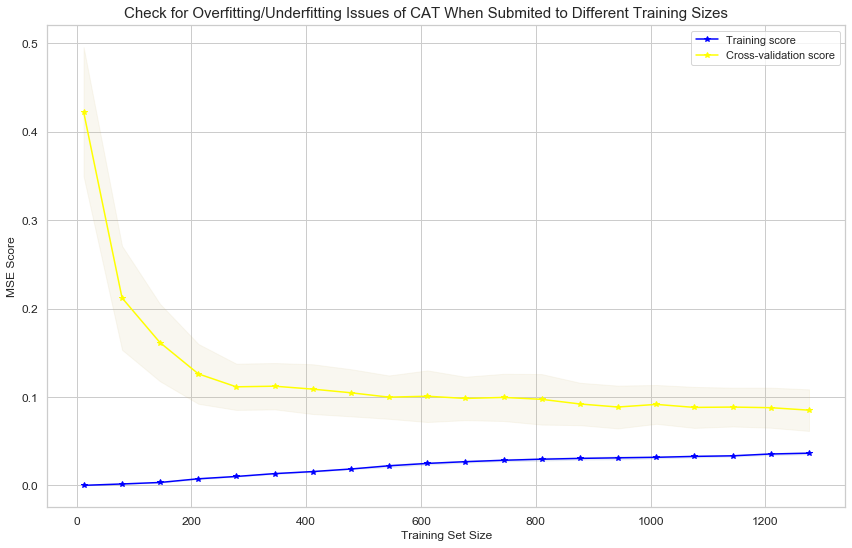

CAT - Train: MSE - -0.028, MAE: -0.126, RMSE: -0.166. , R2: 0.971.
CAT - Test: MSE - 0.049, MAE: 0.150, RMSE: 0.221. , R2: 0.959.
bagging - Feature Importances


bagging - Learning Curve


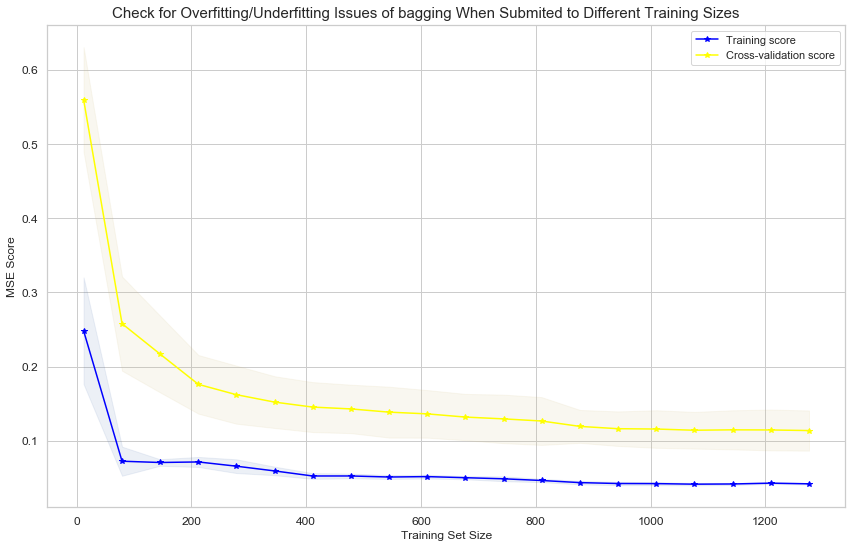

bagging - Train: MSE - -0.044, MAE: -0.139, RMSE: -0.210. , R2: 0.953.
bagging - Test: MSE - 0.131, MAE: 0.227, RMSE: 0.363. , R2: 0.888.


KeyError: 'Test Accuracy'

In [79]:
# RUNNING ALL THE EXPERIMENTS

num_experiments = 30
num_folds = 5
scoring = { 'MSE': 'neg_mean_squared_error',
            'MAE': 'neg_mean_absolute_error',
            'RMSE': 'neg_root_mean_squared_error',
            'R2':'r2'}


all_models = [i[0] for i in models]


for i in np.arange(2,len(classifiers)+1,1):
              all_models.append("blending_" + str(i) + "_best")

all_models.append("bagging")

for i in np.arange(2,len(classifiers)+1,1):
              all_models.append("Voter_" + str(i) + "_best")

all_models.append("stacking")

models_test_mses = pd.DataFrame(columns=all_models)
models_train_mses = pd.DataFrame(columns=all_models)
models_validation_mses = pd.DataFrame(columns=all_models)

average_results = pd.DataFrame(columns=['Model',
                                        'Test MSE',
                                        'Test MAE',
                                        'Test RMSE',
                                        'Test R2',
                                        'Train MSE',
                                        'Train MAE',
                                        'Train RMSE',
                                        'Train R2',
                                        'Validation MSE',
                                        'Validation MAE',
                                        'Validation RMSE',
                                        'Validation R2'
                                        ]
                              )

for i, elem in enumerate(all_models):
    average_results = average_results.append(pd.Series(0, index=average_results.columns), ignore_index=True)
    average_results.ix[i,:]['Model'] = elem

for i in range(0, num_experiments):
    print("\n------------------------------- EXPERIMENT " + str(i+1) + " ------------------------------------")
    
    seed = i
                                                        
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=seed)
    
    models_train_mses = models_train_mses.append(pd.Series(0, index=models_train_mses.columns), ignore_index=True)
    models_validation_mses = models_validation_mses.append(pd.Series(0, index=models_validation_mses.columns), ignore_index=True)
    models_test_mses = models_test_mses.append(pd.Series(0, index=models_test_mses.columns), ignore_index=True)
    
    #Base Models
    for name, model_2 in models:
        average_results,models_test_mses, models_train_mses, models_validation_mses = classify_performance(name, model_2, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)


    #ensemble models
    average_results,models_test_mses, models_train_mses, models_validation_mses  = bagging(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)

    average_results,models_test_mses,models_train_mses, models_validation_mses  = blending(average_results,  models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)
    
    average_results,models_test_mses,models_train_mses, models_validation_mses  = voting(average_results,  models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)
    
    average_results,models_test_mses, models_train_mses, models_validation_mses  = stacking_function(average_results,  models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)


# Analysis of the results

In [ ]:
#calculating the average of the metrics
for key, value in enumerate(all_models): 
    for col in average_results.columns:
        if col != 'Model':
            current = average_results.ix[average_results['Model'] == value][col].values
            division = float(current/num_experiments)

            average_results.iloc[average_results.ix[average_results['Model'] == value].index.values.astype(int)[0]][col] = division

In [ ]:
#sort by the criteria that you want
average_results.sort_values(by=["Test MSE", "Test MAE","Test RMSE"], ascending=True, inplace=True)

display(average_results)

for model in all_models:
    line = pd.DataFrame(columns=average_results.columns)

    line = line.append(pd.Series(average_results.iloc[0, :]), ignore_index=True)
    
    line.to_html('./results/house_prices/' + model + '/average_results.html')
    imgkit.from_file('./results/house_prices/' + model + '/average_results.html', './results/house_prices/' + model + '/average_results.png') # you need to have wkhtmltoimage in your computer  and configure your environmental variable before executing this
    os.remove('./results/house_prices/' + model + '/average_results.html')

In [ ]:
#confusion matrix and roc curves for each algorithm

for index, row in average_results.iterrows():

    name = average_results.iloc[index, 0]
    train_mse = average_results.iloc[index, 1] * (-1)
    test_mse = average_results.iloc[index, 5]
    validation_mse = average_results.iloc[index, 9] * (-1)
    train_mae = average_results.iloc[index, 2]
    test_mae = average_results.iloc[index, 6] * (-1)
    validation_mae = average_results.iloc[index, 10] * (-1)
    train_rmse = average_results.iloc[index, 3]
    test_rmse = average_results.iloc[index, 7] * (-1)
    validation_rmse = average_results.iloc[index, 11] * (-1)
    train_r2 = average_results.iloc[index, 4] * (-1)
    test_r2 = average_results.iloc[index, 8]
    validation_r2 = average_results.iloc[index, 12] * (-1)
    
    performance_metrics = pd.DataFrame(index=['MSE', 'MAE', 'RMSE', 'R2'],columns=['Train','Test', 'Validation'],data=[[train_mse,test_mse,validation_mse],[train_mae,test_mae,validation_mae],
                                                                                [train_rmse,test_rmse,validation_rmse], [train_r2,test_r2,validation_r2]])
    
    
    performance_metrics.plot(figsize=(12,8))
    plt.savefig('./results/house_prices/' + name + '/performance_metrics.png')

    


In [ ]:
my_map = {}
for index,value in enumerate(all_models):
    my_map[index] = value

img_name1 = 'all_MSEs'
img_name2 = 'all_MAEs'
img_name3 = 'all_RMSEs'
img_name4 = 'all_R2'

dload = os.path.expanduser('~\\Downloads')
save_dir = '.\\results\house_prices'

In [ ]:
#Plot of the average of mses of the different algorithms

copy_mse = average_results
copy_mse.sort_values(by=["Test MSE"], ascending=True, inplace=True)
mses_sorted = copy_mse["Test MSE"]
mses_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = mses_sorted.T.iplot(kind = 'bar', color='yellow', asFigure = True, title = 'Average of MSEs of the Different Algorithms (average of the 30 Experiments)', theme = 'pearl')
iplot(figure,filename=img_name1, image='png')


In [ ]:
#Plot of the average of maes of the different algorithms

copy_maes = average_results
copy_maes.sort_values(by=["Test MAE"], ascending=True, inplace=True)
mae_sorted = copy_maes["Test MAE"]
mae_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = mae_sorted.T.iplot(kind = 'bar', color='red', asFigure = True, title = 'MAEs of the Different Algorithms (average of the 30 Experiments)', theme = 'solar')
iplot(figure,filename=img_name2, image='png')

In [ ]:
#Plot of the average of maes of the different algorithms

copy_rmse = average_results
copy_rmse.sort_values(by=["Test RMSE"], ascending=True, inplace=True)
rmse_sorted = copy_rmse["Test RMSE"]
rmse_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = rmse_sorted.T.iplot(kind = 'bar', color='blue', asFigure = True, title = 'RMSEs of the Different Algorithms (average of the 30 Experiments)', theme = 'solar')
iplot(figure,filename=img_name3, image='png')

In [ ]:
#Plot of the r2 of the different algorithms

copy_r2 = average_results
copy_r2.sort_values(by=["Test R2"], ascending=True, inplace=True)
r2_sorted = copy_r2["Test R2"]
r2_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = r2_sorted.T.iplot(kind = 'bar', color='green', asFigure = True, title = 'R2 of the Different Algorithms (average of the 30 Experiments)', theme = 'solar')
iplot(figure,filename=img_name4, image='png')

In [ ]:
# boxplot algorithm comparison
plt.figure(figsize=(20,10))
plt.title('Comparison of the Models MSEs (average of the 30 Experiments)', fontsize=20)
plt.boxplot(models_test_mses.T)
locs, labels=plt.xticks()
x_ticks = []
new_xticks=models_test_mses.columns
plt.xticks(locs,new_xticks, rotation=35, horizontalalignment='right', fontsize = 15)
plt.yticks(fontsize = 20)
plt.savefig('./results/house_prices/boxplot_mses.png')
plt.show()


**Finally, we'll analyze the behavior of validation scores vs training scores vs test scores of each algorithm during the 30 experiments in order to check for overfitting/underfitting issues.**

In [ ]:
experiments_array = np.arange(1, num_experiments+1, 1)
for model in all_models:
    plt.figure(figsize=(20,10))
    plt.plot(experiments_array, models_train_mses[model].T.mul(-1), '*-', color = 'blue',  label = 'Score on Training')
    plt.plot(experiments_array, models_validation_mses[model].T.mul(-1), '*-', color = 'yellow', label = 'Score on Validation')
    plt.plot(experiments_array, models_test_mses[model].T, 'r--',  color = 'red', label = 'Score on Testing') 

    
    font_size = 15
    plt.xlabel('Experiments', fontsize = font_size)
    plt.ylabel('MSE Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')

    plt.suptitle('Training vs Validating vs Testing Scores on ' + model + '', fontsize = 20)

    plt.grid(b=True, color='grey', linestyle='--')
    plt.savefig('./results/house_prices/' + model + '/overfitting_underfitting.png')
    plt.show()

# Statistical Tests and Ranking of the Accuracies

- 1) Ranking the results by rows (experiments)
- 2) Friedman test to see if the null hypothesis that the groups of data are similar can be rejected. 
- 3) Nemenyi test to see if that difference is statistical significative.

In [ ]:
display(models_test_mses)

In [ ]:
#Ranking the results by row (experiment)
models_test_mses_transpose = models_test_mses

models_test_mses_ranked = pd.DataFrame(columns=models_test_mses.columns)
for i in models_test_mses_transpose.iterrows():
    models_test_mses_ranked = models_test_mses_ranked.append(models_test_mses_transpose.iloc[i[0],:].rank(method='dense'), ignore_index=True)
    
temp = models_test_mses_ranked.append(models_test_mses_ranked.sum(numeric_only=True), ignore_index=True)
temp = temp.sort_values(by=num_experiments, axis=1, ascending=True)
temp = temp.iloc[:,:-2]
display(temp)

In [ ]:
# Friedman and nemenyi test
p_values = sp.posthoc_nemenyi_friedman(temp.iloc[0:num_experiments,:])

In [ ]:
#Assuming that p = 0.05, we can say that...
with open('./results/house_prices/statistic_results.txt', 'w') as f:
    for i in range(0, len(p_values.columns)):
        for j in range(0, len(p_values.columns)):
            name1 = p_values.columns[i]
            name2 = p_values.columns[j]
            
            if (j >= i):
                break
            if p_values.iloc[i,j] < 0.01:
                if temp.loc[temp.index[num_experiments], name1] < temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[i] + " is statistically way much better than " + p_values.columns[j], file=f)
                    print("Algorithm " + p_values.columns[i] + " is statistically way much better than " + p_values.columns[j])
                elif temp.loc[temp.index[num_experiments], name1] > temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[j] + " is statistically way much better than " + p_values.columns[i], file=f)
                    print("Algorithm " + p_values.columns[j] + " is statistically way much better than " + p_values.columns[i])
            elif p_values.iloc[i,j] < 0.05:
                if temp.loc[temp.index[num_experiments], name1] < temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[i] + " is statistically better than " + p_values.columns[j], file=f)
                    print("Algorithm " + p_values.columns[i] + " is statistically better than " + p_values.columns[j])
                elif temp.loc[temp.index[num_experiments], name1] > temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[j] + " is statistically better than " + p_values.columns[i], file=f)
                    print("Algorithm " + p_values.columns[j] + " is statistically better than " + p_values.columns[i])

# Interpretability/Explainability

## Check Permutation Importance of Encoded Features

Before encoding we can observe directly which feature is more important for each model (independently if the models have already built-in method like the Random Forest or Logistic Regression). We actually did that already right after tunned the parameters for each model.

However, those results can be misleading once we have categorical features that would be later unfolded in extra numerical features through OneHotEncoding in order to improve the accuracy of our model. So, when we build a permutation feature importance table with the encoded features, we obtain more reliable information. 

In order to not produce an exagerated number of outputs and figures, we'll study the importance of the features of our top 5 most accurate models.

In [ ]:
top = 5
criteria = "Test MSE"

#As stated before, we can't asses feature importance of stacking ensemble model
copy_3 = average_results[average_results.Model != 'stacking']
copy_3.sort_values(by=[criteria], ascending=True, inplace=True) # We can easily see the contribution of each feature to increase the precision or recall or any other scoring method (depending on the needs of our problem).

clfs_names = list(copy_3.iloc[1:top,0])

for name in clfs_names:
    for value in every_model:
        if(value[0] == name):
            model = value[1]
            print(name + " - Encoded Feature Importances")
            permutation_importance(model, X_test, Y_test)
            break
    

The values describe the average change in performance of the model when we permute the corresponding feature. Negative values mean that the model accuracy actually improved when the feature values were permuted
 
We need to be analyze this table as groups of features originated from primordial features, and we have to see which of these groups are predominantly at the top.

We can also compare how the feature importance of these encoded primordial features vary relative to the feature importance of the primordial features.

# Preparing the Submission with the Best Model

In [ ]:
#finding the Best Model
copy_4 = average_results[average_results.Model.isin([i[0] for i in models])]
copy_4.sort_values(by=["Test MSE"], ascending=True, inplace=True)

best_model_name = copy_4.iloc[0:1,0].values

for clf in every_model:
    if clf[0] == best_model_name:
        best_model = clf[1]
        break


In [ ]:
#Preparing a submission of the model that have the best score

test = pd.read_csv("./data/house_prices/test.csv")
Ids = test['Id']
X = test.drop('Id',axis=1)

features_transformed = pipeline.transform(X)
predictions = best_model.predict(features_transformed)
predictions = pd.Series(scaler_2.inverse_transform(predictions))

submission = pd.DataFrame({'Id':Ids, 'SalePrice':predictions})

submission.to_csv("submission.csv", index=False)


# Making New Predictions with the Best Model

What is the purpose of developing a new ultra optimized model if we can't use it for making predictions on unknown data? Bellow, we'll try to predict the outcome of our model given a new example of entry.

In order to this in an efficient way, it is necessary to make use of pipelines to help us transform or inverse the transformation of the features.

In [ ]:
#easily getting a random example
#Load Data
df = pd.read_csv('./data/house_prices/train.csv')

df.drop(['Id'], axis=1, inplace=True)

#random example - the result should be close to 208500
new_data = df.iloc[0:1, :-1].values.tolist()[0]

In [ ]:
#reorder the data because the models were trained with other order
features = pd.DataFrame(columns=original_order).append(pd.Series(new_data, index=original_order), ignore_index=True)

features = features[new_order]

In [ ]:
#import preprocessing pipeline
pipeline = joblib.load('./models/house_prices/preprocessing_pipeline.pkl')

#preprocess the features of our new data
features_transformed = pipeline.transform(features)

#alternatively we can just import one model from the saved ones
"""
best_model_name = 'SVR'
best_model = joblib.load('./models/house_prices/' + best_model_name +'_model.sav')
columns = columns = numerical + pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical).tolist()
features_transformed = pd.DataFrame(features_transformed.toarray(), columns=columns)
"""

if best_model_name == 'Gaussian' or best_model_name == 'SVR':
    prediction = best_model.predict(features_transformed.toarray()) #there's this little issue with Gaussian and SVR
else:
    prediction = best_model.predict(features_transformed)

prediction = pd.DataFrame(scaler_2.inverse_transform(prediction))

print('The price of the house will be %.2f!' % float(prediction.values))

# (Optional Advanced Optimization 1) Iterations of Feature Selection/Feature Creation 

- Deep Feature Synthesis - [Source](https://www.kaggle.com/willkoehrsen/featuretools-for-good)
    - Min, max, etc
    - Squared, Cubed, etc
- Combination of Features
- Clustering, t-SNE, etc

In [ ]:
#Implementation for Deep Feature Synthesis
"""
for col in X.columns:
    feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = col, 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_contains = list(all_features),
                                       max_depth = 2, max_features = 100,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 1000)


    all_features += [str(x.get_name()) for x in feature_names_add]
    X = pd.concat([X, feature_matrix_add], axis = 1)
"""
#Next it is important to do all the pre processing again before training/testing the model. 
#Many iterations of Feature Creation and Selection might be needed to improve the model a little bit.

In [ ]:
#saving the plotly images
copyfile('{}\\{}.png'.format(dload, img_name1),
     '{}\\{}.png'.format(save_dir, img_name1))

copyfile('{}\\{}.png'.format(dload, img_name2),
     '{}\\{}.png'.format(save_dir, img_name2))

copyfile('{}\\{}.png'.format(dload, img_name3),
     '{}\\{}.png'.format(save_dir, img_name3))
copyfile('{}\\{}.png'.format(dload, img_name4),
     '{}\\{}.png'.format(save_dir, img_name4))